# Trabalho de Introdução à Ciência de Dados - Equity in Athletics (Equidade no Atletismo)

## Membros
Cecília Junqueira - 2022094888

Carolina Pilla -2022043299


Felipe Gomide - 2022043213

Lucas Junqueira - 2022043264

## Informações

* Base de dados do Departamentodde Educação dos E.U.A.: o [Equity in Athletics](https://ope.ed.gov/athletics/#/datafile/list) -  2006 à 2021
* A base engloba dados sobre equipes esportivas em faculdades americanas, considerando 43 esportes. Nosso foco é na receita (lucro e gastos) das faculdades e nas proporções de homens e mulheres.st

## Referências
* Best D1 Colleges. Disponível em: <https://www.ncsasports.org/best-colleges/best-division-1-colleges>. Acesso em: 16 ago. 2024.
* US Census Bureau - Cartographic Boundary File. Disponível em: <https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2014.html#list-tab-1556094155>. Acesso em: 16 ago. 2024.

## Setup Inicial

Instalação de biblioteca auxiliar e imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
#from adjustText import adjust_text
import numpy as np
import io

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Processamento dos Dados

## União dos dados de todos os anos

In [2]:
df = pd.read_excel("https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_2006.xls")
df['YEAR'] = 2006

to_concat = []
to_concat.append(df)
for ano in range(2007, 2012):
    df_aux = pd.read_excel(f"https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_{ano}.xls")
    df_aux['YEAR'] = ano

    to_concat.append(df_aux)

for ano in range(2012, 2022):
    df_aux = pd.read_excel(f"https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_{ano}.xlsx")
    df_aux['YEAR'] = ano

    to_concat.append(df_aux)

df = pd.concat(to_concat)
df

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


unitid          institution_name              addr1_txt  \
0      100654  Alabama A & M University       4900 Meridian St   
1      100654  Alabama A & M University       4900 Meridian St   
2      100654  Alabama A & M University       4900 Meridian St   
3      100654  Alabama A & M University       4900 Meridian St   
4      100654  Alabama A & M University       4900 Meridian St   
...       ...                       ...                    ...   
17639  800001   Simon Fraser University  8888 University Drive   
17640  800001   Simon Fraser University  8888 University Drive   
17641  800001   Simon Fraser University  8888 University Drive   
17642  800001   Simon Fraser University  8888 University Drive   
17643  800001   Simon Fraser University  8888 University Drive   

                          addr2_txt city_txt state_cd zip_text  \
0                               NaN   Normal       AL    35762   
1                               NaN   Normal       AL    35762   
2                               NaN   Normal       AL    35762   
3                               NaN   Normal       AL    35762   
4                               NaN   Normal       AL    35762   
...                             ...      ...      ...      ...   
17639  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17640  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17641  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17642  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17643  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   

       ClassificationCode             classification_name ClassificationOther  \
0                       2              NCAA Division I-AA                 NaN   
1                       2              NCAA Division I-AA                 NaN   
2                       2              NCAA Division I-AA                 NaN   
3                       2              NCAA Division I-AA                 NaN   
4                       2              NCAA Division I-AA                 NaN   
...                   ...                             ...                 ...   
17639                   4  NCAA Division II with football                 NaN   
17640                   4  NCAA Division II with football                 NaN   
17641                   4  NCAA Division II with football                 NaN   
17642                   4  NCAA Division II with football                 NaN   
17643                   4  NCAA Division II with football                 NaN   

       ...  TOTAL_EXP_MENWOMEN  EXP_COED_MEN  EXP_COED_WOMEN  TOTAL_EXP_COED  \
0      ...            185984.0           NaN             NaN             NaN   
1      ...            987673.0           NaN             NaN             NaN   
2      ...           1468708.0           NaN             NaN             NaN   
3      ...             43988.0           NaN             NaN             NaN   
4      ...            460846.0           NaN             NaN             NaN   
...    ...                 ...           ...             ...             ...   
17639  ...            855784.0           NaN             NaN             NaN   
17640  ...            248662.0           NaN             NaN             NaN   
17641  ...            562200.0           NaN             NaN             NaN   
17642  ...            329452.0           NaN             NaN             NaN   
17643  ...            430420.0           NaN             NaN             NaN   

      EXPENSE_MENALL  EXPENSE_WOMENALL  TOTAL_EXPENSE_ALL      Sports  YEAR  \
0             185984                 0             185984    Baseball  2006   
1             543356            444317             987673  Basketball  2006   
2            1468708                 0            1468708    Football  2006   
3              43988                 0              43988        Golf  2006   
4             217410            243436             460846      Soccer  2006   
...          

## Seleção dos atributos de interesse - Primeira Pergunta

In [3]:
#Seleção das colunas de interesse
aux = df[['SUM_PARTIC_MEN', 'SUM_PARTIC_WOMEN', 'Sports', 'YEAR', 'state_cd', 'TOTAL_OPEXP_INCLCOED', "SUM_TOTAL_HDCOACH", "SUM_TOTAL_ASSTCOACH", "TOTAL_REVENUE_ALL", "TOTAL_EXPENSE_ALL"]].reset_index(drop=True)

# Nova coluna, total de participantes
aux['TOTAL_PARTIC'] = aux['SUM_PARTIC_MEN'] + aux['SUM_PARTIC_WOMEN']

aux.shape

(313736, 11)

In [4]:
# Modalidades com erro de digitação ou alguma mudança de categorização a partir dos anos
rename = {"Track and Field and Cross Country (combined)": "All Track Combined",
          "Swimming and Diving (combined)": "Swimming and Diving",
          "Field hocky": "Field Hockey"}


# Modalidades que já estão contidas em algum grupo serão removidas
to_drop = ["Track and Field, Indoor", "Track and Field, Outdoor", "Track and Field, X-Country",
           "Track and Field (Indoor)", "Track and Field (Outdoor)", "Swimming",
           "Synchronized Swimming", "Synchronized swimming", "Diving", "Cross Country",
            "Team Handball", "Table Tennis", "Badminton", "Archery", "Weight Lifting", "Rifle", # Esta linha: modalidades com menos de 10 mil atletas todos os anos
           "Other Sports"] # Conjunto de esportes, sem muita informação, possivelmente muito variados

aux = aux.replace(rename)
aux = aux[~aux['Sports'].isin(to_drop)]

In [5]:
data = aux.groupby(by=['YEAR', 'Sports', 'state_cd']).sum().reset_index()
data.to_csv("tabelas_pre_processadas/modalidades_por_estado.csv", index=False)

## Seleção de atributos interessantes - **PERGUNTA 2**

In [6]:
df_filtered = df[["YEAR", "institution_name", "state_cd", "SPORTSCODE", "REV_MEN", "REV_WOMEN", "TOTAL_REV_MENWOMEN", "REV_COED_MEN", "REV_COED_WOMEN", "TOTAL_REV_COED", "REVENUE_MENALL", "REVENUE_WOMENALL", "TOTAL_REVENUE_ALL", "EXP_MEN", "EXP_WOMEN", "EFFemaleCount", "EFMaleCount"]]
df_filtered.drop(df_filtered[df_filtered["state_cd"].isnull() == True].index, inplace=True)
df_filtered = df_filtered.groupby(["YEAR", "state_cd", "SPORTSCODE"], as_index = False)[["REV_MEN", "REV_WOMEN", "EXP_MEN", "EXP_WOMEN", "EFFemaleCount", "EFMaleCount"]].sum()

df_filtered["LUCRO_MEN"] = df_filtered["REV_MEN"] - df_filtered["EXP_MEN"]
df_filtered["LUCRO_WOMEN"] = df_filtered["REV_WOMEN"] - df_filtered["EXP_WOMEN"]
df_filtered[3:] = df_filtered[3:].fillna(0)

#df_filtered.to_csv("tabelas_pre_processadas/lucro_participacao.csv", index=False)

<ipython-input-6-47081910294d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(df_filtered[df_filtered["state_cd"].isnull() == True].index, inplace=True)


## Seleção dos atributos interessantes - Pergunta 3

In [94]:
# Retirando escolas unicamente masculinas ou femininas:
data_3 = df
data_3[['PARTIC_MEN', 'PARTIC_WOMEN']] = data_3[['PARTIC_MEN', 'PARTIC_WOMEN']].fillna(0)
data_3 = df.query('PARTIC_WOMEN != 0 & PARTIC_MEN !=0')

In [95]:
# Coletando dados de interesse para o plot do mapa US
diff_states_plot = data_3[['state_cd','PARTIC_MEN','PARTIC_WOMEN','YEAR']]
diff_states_plot = diff_states_plot.query("state_cd != 'BC'")
diff_states_plot['Total'] = diff_states_plot['PARTIC_MEN'] + diff_states_plot['PARTIC_WOMEN']
diff_states_plot = diff_states_plot.groupby(['state_cd'])[['Total','PARTIC_MEN','PARTIC_WOMEN']].sum()
diff_states_plot.reset_index(inplace=True)
diff_states_plot['Porcentagem_Mulheres'] = ( diff_states_plot['PARTIC_WOMEN'] / diff_states_plot['Total'] ) * 100
diff_states_plot['Porcentagem_Homens'] = ( diff_states_plot['PARTIC_MEN'] / diff_states_plot['Total'] ) * 100
diff_states_plot = diff_states_plot[["state_cd","Porcentagem_Mulheres"]]

In [96]:
# Coletando dados de interesse para o plot os Estados no Tempo
states_time_3 = data_3[['state_cd','PARTIC_MEN','PARTIC_WOMEN','YEAR']]
states_time_3 = states_time_3.query("state_cd != 'BC'")
states_time_3['Total'] = states_time_3['PARTIC_MEN'] + states_time_3['PARTIC_WOMEN']
states_time_3 = states_time_3.groupby(['state_cd', 'YEAR'])[['Total','PARTIC_MEN','PARTIC_WOMEN']].sum()
states_time_3.reset_index(inplace=True)
states_time_3['Porcentagem_Mulheres'] = ( states_time_3['PARTIC_WOMEN'] / states_time_3['Total'] ) * 100
states_time_3['Porcentagem_Homens'] = ( states_time_3['PARTIC_MEN'] / states_time_3['Total'] ) * 100
states_time_3 = states_time_3[["state_cd","YEAR","Porcentagem_Mulheres"]]
states_time_3 = states_time_3[states_time_3['state_cd'].isin(['KS', 'CO', 'IA', 'UT', 'ID', 'LA', 'HI', 'CA', 'NC', 'NV'])]

In [97]:
# Coletando dados de interesse para o plot de boxplots para o teste de hipótese
box_hip = data_3[['institution_name','state_cd','PARTIC_MEN','PARTIC_WOMEN','YEAR']]
box_hip['Total'] = box_hip['PARTIC_MEN'] + box_hip['PARTIC_WOMEN']
box_hip = box_hip.groupby(['state_cd','institution_name'])[['Total','PARTIC_MEN','PARTIC_WOMEN']].sum()
box_hip.reset_index(inplace=True)
box_hip['Porcentagem_Mulheres'] = ( box_hip['PARTIC_WOMEN'] / box_hip['Total'] ) * 100
box_hip['Porcentagem_Homens'] = ( box_hip['PARTIC_MEN'] / box_hip['Total'] ) * 100

KS = box_hip.query("state_cd == 'KS'")
KS = KS['Porcentagem_Mulheres']
UT = box_hip.query("state_cd == 'UT'")
UT = UT['Porcentagem_Mulheres']

states_hip_3 = [KS, UT]

<ipython-input-97-6515deb64435>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_hip['Total'] = box_hip['PARTIC_MEN'] + box_hip['PARTIC_WOMEN']


In [98]:
# Coletando dados de interesse para o teste de permutação
perm_3 = data_3[['institution_name','state_cd','PARTIC_MEN','PARTIC_WOMEN','YEAR']]
perm_3 = perm_3.query("state_cd == 'KS' | state_cd == 'UT'")
perm_3['Total'] = perm_3['PARTIC_MEN'] + perm_3['PARTIC_WOMEN']
perm_3 = perm_3.groupby(['state_cd','institution_name'])[['Total','PARTIC_MEN','PARTIC_WOMEN']].sum()
perm_3.reset_index(inplace=True)
perm_3['Porcentagem_Mulheres'] = ( perm_3['PARTIC_WOMEN'] / perm_3['Total'] ) * 100
perm_3['Porcentagem_Homens'] = ( perm_3['PARTIC_MEN'] / perm_3['Total'] ) * 100

In [99]:
# Coletando dados de interesse para a regressão logistica
reg_log_3 = data_3[data_3['state_cd'].isin(['KS', 'WA', 'SC'])]

## Seleção dos atributos de interesse - Pergunta 4

In [56]:
df_copy_4 = df.copy()
df_copy_4.drop(df[df['Sports'] == 'team handball'].index, inplace=True)
df_copy_4.replace({'Field hocky' : 'Field Hockey'}, inplace =True)
df_copy_4.replace({'Synchronized swimming' : 'Synchronized Swimming'}, inplace =True)

df_temp = pd.read_csv(io.StringIO('''
MEN_FTHEADCOACH_MALE,MEN_PTHEADCOACH_MALE,MEN_FTUNIVEMPLOY_MALE,MEN_PTUNIVEMPLOY_MALE,MEN_FTHEADCOACH_FEM,MEN_PTHEADCOACH_FEM,MEN_FTUNIVEMPLOY_FEM,MEN_PTUNIVEMPLOY_FEM,MEN_TOTAL_HEADCOACH,WOMEN_FTHDCOACH_MALE,WOMEN_PTHDCOACH_MALE,WOMEN_FTUNIVEMP_MALE,WOMEN_PTUNIVEMP_MALE,WOMEN_FTHDCOACH_FEM,WOMEN_PTHDCOACH_FEM,WOMEN_FTUNIVEMP_FEM,WOMEN_PTUNIVEMP_FEM,WOMEN_TOTAL_HDCOACH,COED_FTHDCOACH_MALE,COED_PTHDCOACH_MALE,COED_FTUNIVEMP_MALE,COED_PTUNIVEMP_MALE,COED_FTHDCOACH_FEM,COED_PTHDCOACH_FEM,COED_FTUNIVEMP_FEM,COED_PTUNIVEMP_FEM,COED_TOTAL_HDCOACH,SUM_FTHDCOACH_MALE,SUM_PTHDCOACH_MALE,SUM_FTUNIVEMP_MALE,SUM_PTUNIVEMP_MALE,SUM_FTHDCOACH_FEM,SUM_PTHDCOACH_FEM,SUM_FTUNIVEMP_FEM,SUM_PTUNIVEMP_FEM,SUM_TOTAL_HDCOACH,MEN_FTASCOACH_MALE,MEN_PTASCOACH_MALE,MEN_FTACUNIVEMP_MALE,MEN_PTACUNIVEMP_MALE,MEN_FTASSTCOACH_FEM,MEN_PTASSTCOACH_FEM,MEN_FTACUNIVEMP_FEM,MEN_PTACUNIVEMP_FEM,MEN_TOTAL_ASSTCOACH,WOMEN_FTASCOACH_MALE,WOMEN_PTASCOACH_MALE,WOMEN_FTACUNEMP_MALE,WOMEN_PTACUNEMP_MALE,WOMEN_FTASTCOACH_FEM,WOMEN_PTASTCOACH_FEM,WOMN_FTACUNIVEMP_FEM,WOMN_PTACUNIVEMP_FEM,WOMEN_TOTAL_ASTCOACH,COED_FTASCOACH_MALE,COED_PTASCOACH_MALE,COED_FTACUNEMP_MALE,COED_PTACUNEMP_MALE,COED_FTASTCOACH_FEM,COED_PTASTCOACH_FEM,COED_FTACUNIVEMP_FEM,COED_PTACUNIVEMP_FEM,COED_TOTAL_ASTCOACH,SUM_FTASCOACH_MALE,SUM_PTASCOACH_MALE,SUM_FTACUNIVEMP_MALE,SUM_PTACUNIVEMP_MALE,SUM_FTASCOACH_FEM,SUM_PTASCOACH_FEM,SUM_FTACUNIVEMP_FEM,SUM_PTACUNIVEMP_FEM,SUM_TOTAL_ASSTCOACH
'''), header=None)

df_temp.columns = df_temp.iloc[0]
list_drop_columns = df_temp.columns.values.tolist()

for aux in list_drop_columns:
  df_copy_4 = df_copy_4.drop(aux, axis=1)

Essa tabela será adicionada ao GitHub, para evitar o tempo de processamento de todos os dados, durante a realização das análises.

# Pergunta 1: Quais são as modalidades esportivas com maiores investimentos em comissão técnica e contratações?

Após uma análise mais minuciosa do conteúdo das tabelas, percebi que não existe informação suficiente pra quantificar esse tipo de investimento, apenas investimento no geral. Por isso, tive o enfoque nas diferenças de investimento total e no número de participantes de cada modalidade esportiva.

## Importando as tabelas

Tabela processada anteriormente do GitHub e tabela auxiliar com informações geográficas para desenho dos mapas.

In [57]:
data = pd.read_csv("https://raw.githubusercontent.com/FelipeGomide/ICD-EquityInAthletics/master/tabelas_pre_processadas/modalidades_por_estado.csv")
data = data.drop(columns = 'Unnamed: 0')

states = geopandas.read_file('https://raw.githubusercontent.com/joncutrer/geopandas-tutorial/master/data/usa-states-census-2014.shp')
states = states[['STUSPS','geometry','NAME']]

states['coords'] = states['geometry'].apply(lambda x: x.representative_point().coords[:])
states['coords'] = [coords[0] for coords in states['coords']]

states = states.drop_duplicates()
states.head()

STUSPS                                           geometry  \
0     CA  MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,...   
1     DC  POLYGON Z ((-77.11976 38.93434 0.00000, -77.04...   
2     FL  MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...   
3     GA  POLYGON Z ((-85.60516 34.98468 0.00000, -85.47...   
4     ID  POLYGON Z ((-117.24303 44.39097 0.00000, -117....   

                   NAME                                    coords  
0            California  (-119.99801052849335, 37.28174301887195)  
1  District of Columbia          (-76.99941630322527, 38.8985315)  
2               Florida  (-81.46903023691782, 27.829472655957098)  
3               Georgia          (-83.25208819002944, 32.6942025)  
4                 Idaho          (-115.4690017868439, 45.5079375)

## Análise Exploratória: Plotando mapas e gráficos de evolução no tempo

### Geração de Mapas, quantidade de participantes por modalidade

Aqui criei uma função que plota um mapa dos Estados Unidos contendo as informações de número de atletas por estado.
Existe a opção de salvar os dados numa pasta, e de mostrar ou não o gráfico após execução.

In [58]:
def plot_modalidade(states, aux, modalidade, ano, save=False, show=True):

    # Seleciono o ano e esporte de interesse no dataframe
    esporte = aux.loc[aux['Sports'] == f'{modalidade}']
    modal = esporte.loc[esporte['YEAR'] == ano]

    #Agrego os dados de mapas no dataframe
    map = states.merge(modal, left_on='STUSPS', right_on='state_cd', how='left')
    map = map[['geometry', 'TOTAL_PARTIC', 'STUSPS', 'NAME', 'coords']]

    f, ax = plt.subplots()
    f.set_size_inches(14, 12)

    map.plot(
        ax=ax,
        column='TOTAL_PARTIC',
        cmap='Oranges',
        edgecolor="black",
        linewidth=0.4,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "black",
            "label": "Missing values",
        },
    )

    texts = []

    for idx, row in map.iterrows():
        texts.append(ax.text(row.coords[0], row.coords[1], s=row['NAME'], horizontalalignment='center',)) #bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

    sm = plt.cm.ScalarMappable(
        cmap="Oranges",                      # Usa o mesmo cmap do mapa
        norm=plt.Normalize(
            vmin= 0,  # Valor mínimo
            vmax=map["TOTAL_PARTIC"].max(),  # Valor máximo
        ),
    )

    cax = f.add_axes(
        [
            0.9,    # posicao x (entre 0.0 e 1.0)
            0.3,    # posicao y (entre 0.0 e 1.0)
            0.03,    # largura x
            0.40,    # altura y
        ]
    )

    ax.set_title(f'Quantity of Athletes by State, {modalidade} {ano}', fontdict={"fontsize": 16})
    ax.axis('off')

    # A linha abaixo utiliza a biblioteca que otimiza o posicionamento dos textos no plot
    # Melhora bastante a visualização dos nomes, já que evita sobreposição,
    # porém afeta bastante o desempenho
    #adjust_text(texts, time_lim=30, arrowprops=dict(arrowstyle='-', color='black', alpha=1), ax=ax)

    f.colorbar(sm, cax=cax)

    if save:
        plt.savefig(f'images/{modalidade}{ano}.jpg', bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else: plt.close()

In [59]:
#Gerando imagem de todas as modalidades
!mkdir images

modalidades = data['Sports'].drop_duplicates().sort_values().reset_index(drop=True)
for sport in modalidades:
    plot_modalidade(states, data, sport, 2017, save=True, show=False)



mkdir: cannot create directory ‘images’: File exists


Geralmente, esse é o padrão observado em todas as tabelas:

Mesmo com escalas diferentes, a distribuição dos atletas é similar, os estados do Texas, Califórnia, Nova York e Pennsylvania dominam em quase todos os cenários.

![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Football2017.jpg?raw=1)|![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Soccer2017.jpg?raw=1)
:-------------------------:|:-------------------------:
![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Basketball2017.jpg?raw=1)|![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/All%20Track%20Combined2017.jpg?raw=1)

Porém, existem alguns cenários diferentes, por motivos distintos, aqui estão alguns exemplos:

- Influenciados pela localização geográfica, seja pelo clima, ou proximidade do litoral:

![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Ice%20Hockey2017.jpg?raw=1)|![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Skiing2017.jpg?raw=1)
:-------------------------:|:-------------------------:
![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Beach%20Volleyball2017.jpg?raw=1)|![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Sailing2017.jpg?raw=1)

- Influenciados por questões culturais:

![](https://github.com/FelipeGomide/ICD-EquityInAthletics/blob/master/images/Rodeo2017.jpg?raw=1)

### Gráficos de Evolução das Modalidades ao passar do tempo

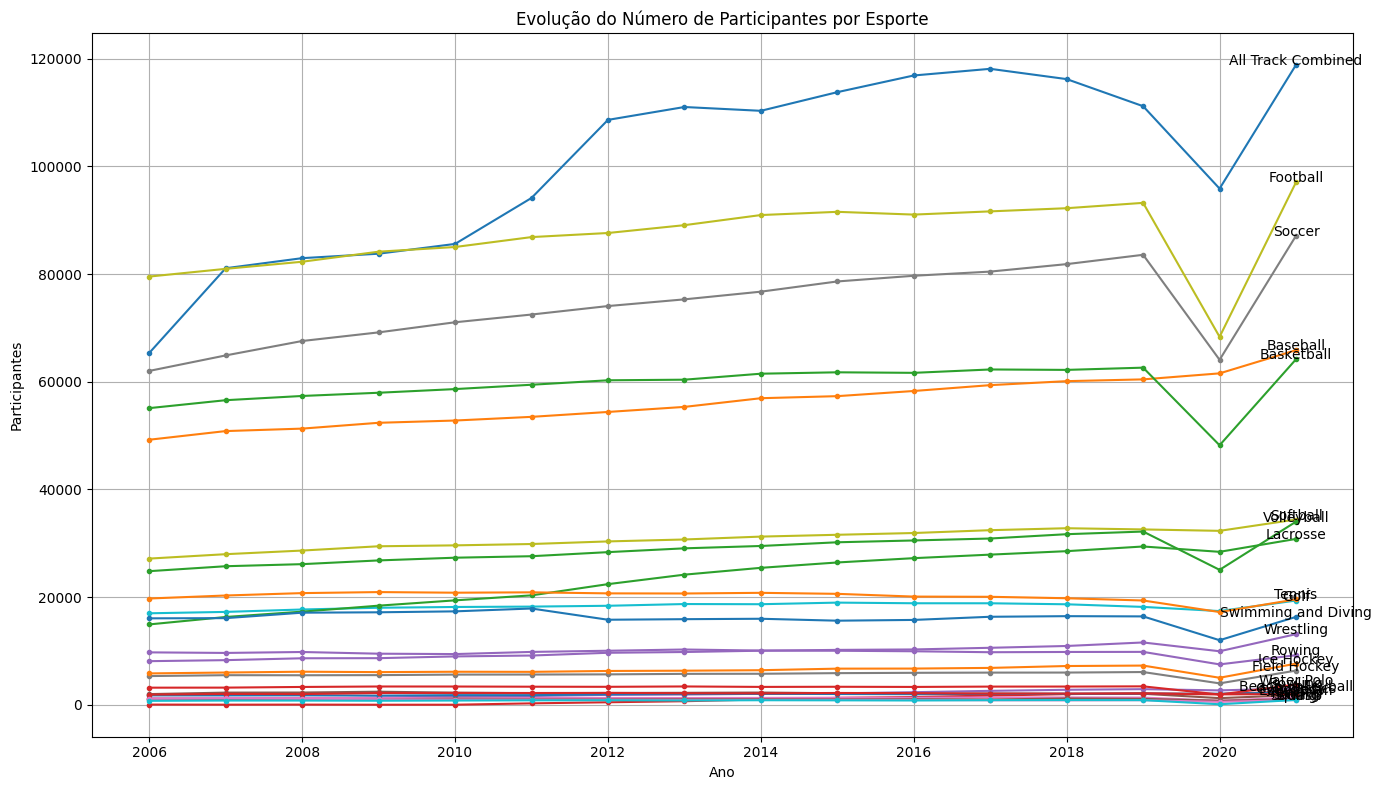

In [60]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_PARTIC']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

texts = []

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_PARTIC'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_PARTIC']

    texts.append(ax.text(info.iloc[-1]['YEAR'], ultimo_participantes, sport, horizontalalignment='center',))

    #ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                #textcoords='offset points', ha='left', va='baseline')

ax.set_xlabel('Ano')
ax.set_ylabel('Participantes')
ax.set_title('Evolução do Número de Participantes por Esporte')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#adjust_text(texts, time_lim=30, arrowprops=dict(arrowstyle='-', color='black', alpha=1), ax=ax)

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

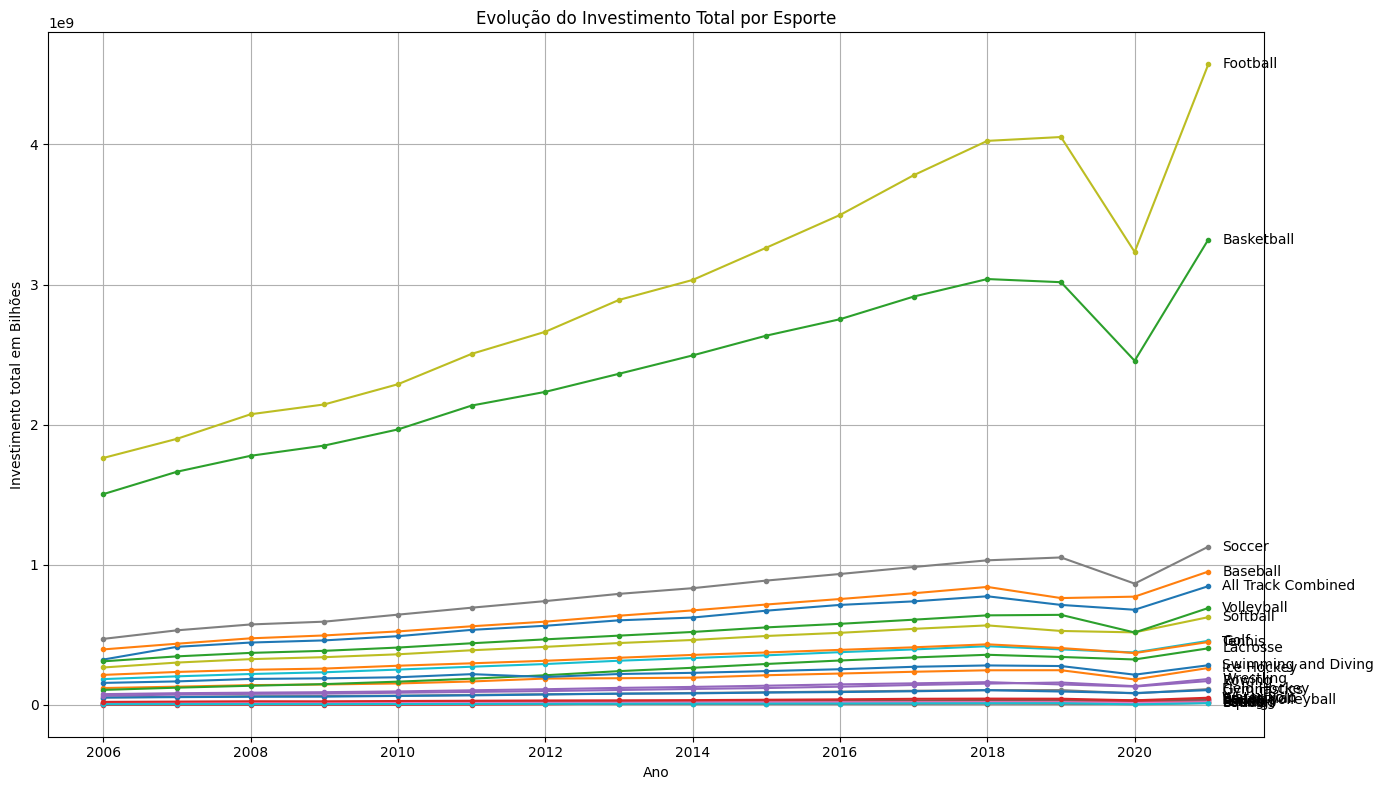

In [61]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_EXPENSE_ALL']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_EXPENSE_ALL'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_EXPENSE_ALL']
    ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center')

ax.set_xlabel('Ano')
ax.set_ylabel('Investimento total em Bilhões')
ax.set_title('Evolução do Investimento Total por Esporte')
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

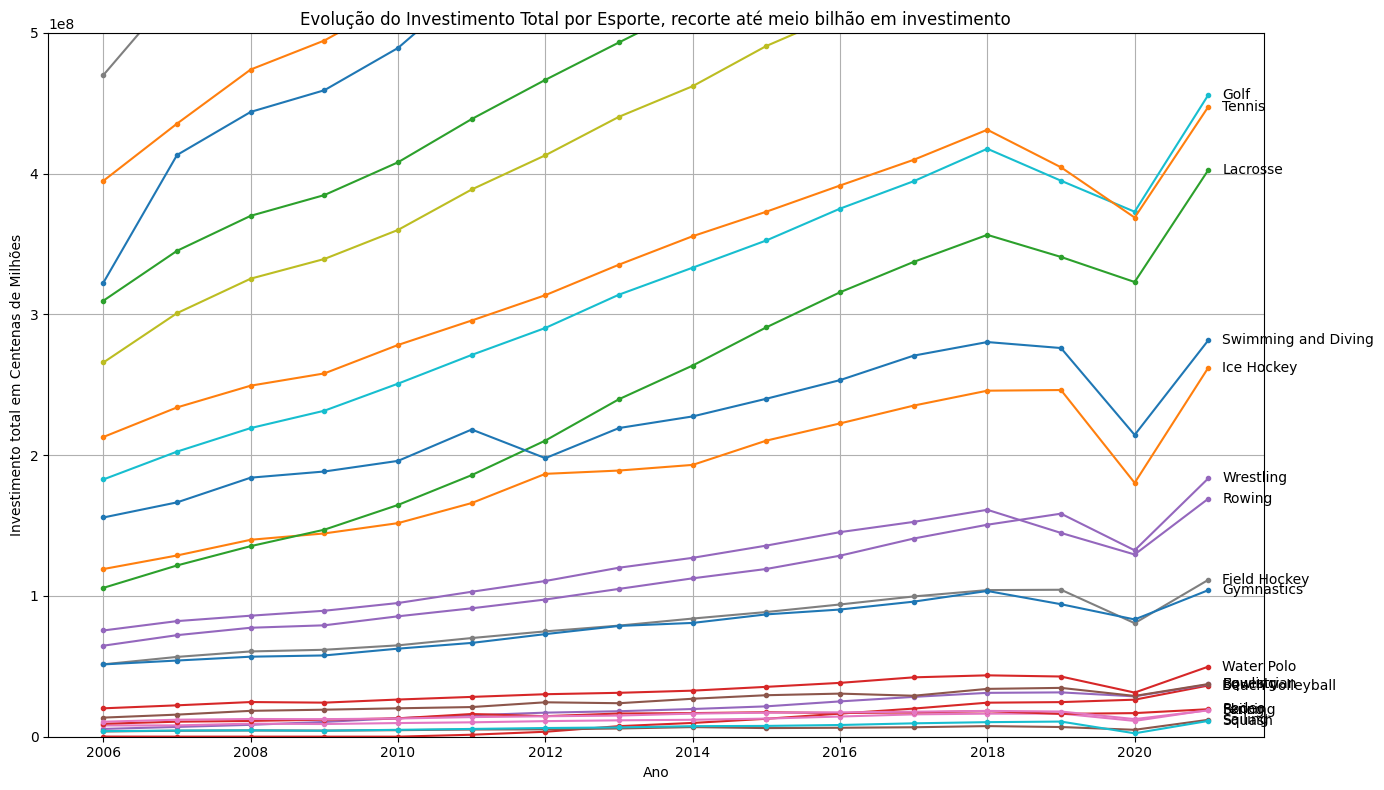

In [62]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_EXPENSE_ALL']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_EXPENSE_ALL'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_EXPENSE_ALL']
    ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center')

ax.set_xlabel('Ano')
ax.set_ylabel('Investimento total em Centenas de Milhões')
ax.set_title('Evolução do Investimento Total por Esporte, recorte até meio bilhão em investimento')
ax.set_ylim(0, 500_000_000)
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

### Resultados

Observamos que na questão de número de atletas, existem várias modalidades que dividem o total de atletas, porém o atletismo é a líder nesse quesito, já que é um compilado de muitas modalidades.

Apesar disso, o gráfico de investimento mostra um cenário bem diferente e muito mais desigual.
Futebol Americano e Basquete dominam o cenário em todos os anos. O Atletismo que antes era o primeiro em número de atletas, tem cerca de 12% do investimento do Futebol Americano.

É perceptível que o número de atletas tem uma certa regularidade através dos anos, os números não aumentam muito, porém o investimento tem crescido a cada ano, o que significa que o investimento por atleta tem aumentado bastante.

Todos os valores sofreram uma queda em 2020, provavelmente em decorrência da pandemia de Covid-19.

## Intervalo de Confiança

In [63]:
def bootstrap_mean(df, column, n=5000, size=None):
    '''
    Faz um boostrap da média da coluna escolhida. Gera amostras.

    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df[column].sample(size, replace=True)
        values[i] = sample.mean()
    return values

### A liderança em popularidade do Futebol Americano pode ser explicada pelo acaso?

O boxplot que mostra os intervalos de confiança mostra que não, o intervalo de bootstrap do Futebol Americano é muito distinto dos outros esportes, ou seja, do ponto de vista estatístico, existe um claro viés que influencia no investimento do esporte.

O plot seguinte mostra a mesma relação, porém analisada sobre os investimentos em atletismo, este mostra que o atletismo está contido no intervalo de confiança, logo o acaso explica seus valores de investimento.

<Axes: >

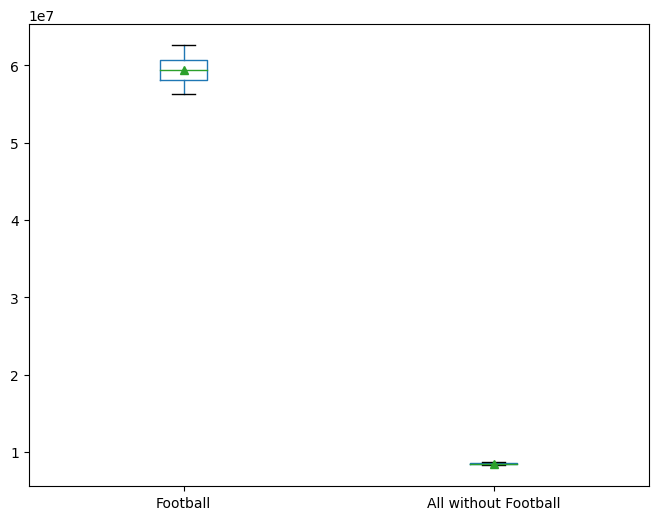

In [64]:
football = data.loc[data["Sports"] == "Football"]
no_football = data.loc[data["Sports"] != "Football"]

football_mean = bootstrap_mean(football, "TOTAL_EXPENSE_ALL")
all_mean = bootstrap_mean(no_football, "TOTAL_EXPENSE_ALL")

to_plot = pd.DataFrame()
to_plot['Football'] = football_mean
to_plot['All without Football'] = all_mean

to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)

<Axes: >

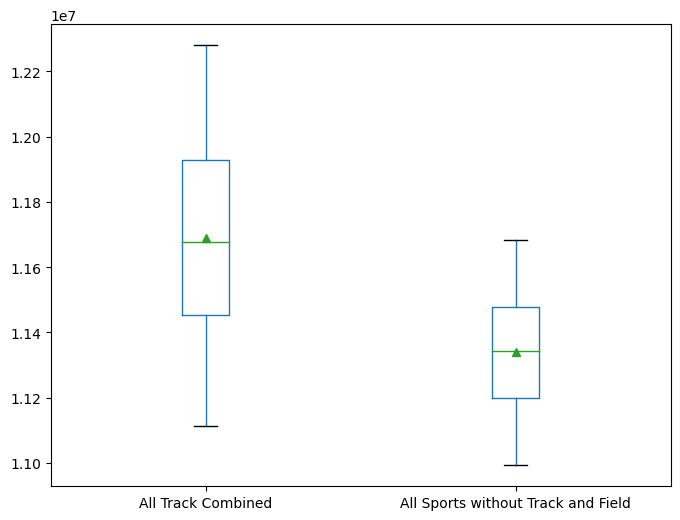

In [65]:
atletismo = data.loc[data["Sports"] == "All Track Combined"]
all = data.loc[data["Sports"] != "All Track Combined"]

atletismo_mean = bootstrap_mean(atletismo, "TOTAL_EXPENSE_ALL")
all_mean = bootstrap_mean(all, "TOTAL_EXPENSE_ALL")

to_plot = pd.DataFrame()
to_plot['All Track Combined'] = atletismo_mean
to_plot['All Sports without Track and Field'] = all_mean

to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)

# Pergunta 2: Diferença de investimento nos esportes entre os estados norte-americanos ao longo dos anos

A desigualdade entre homens e mulheres nos esportes é um tema discutido recorrentemente. Ao propor a pergunta apresentada acima, buscamos analisar não apenas essa desigualdade de investimento nas modalidades esportivas masculinas e femininas, como também buscamos investigar se a diferença de investimento nos esportes difere de maneira significativa entre os estados americanose ao longo dos anos.

## Análise Exploratória

### Construção de estruturas básicas para implementar as análises referentes à pergunta 2

In [66]:
# Construção de um dicionário que atribui a cada esporte um código

df_sports = df[["Sports", "SPORTSCODE"]].drop_duplicates()

code_sport = {}
for index, row in df_sports.iterrows():
  if row["SPORTSCODE"] not in code_sport.keys():
    code_sport[row["SPORTSCODE"]] = row["Sports"]

myKeys = list(code_sport.keys())
myKeys.sort()
sorted_dict = {i: code_sport[i] for i in myKeys}

In [67]:
# Construção de listas com as siglas de todos os estados norte-americanos e de todos os anos com os quais estamos trabalhando

estados = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR', 'VI', 'BC']

years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

### Análise do investimento que cada esporte recebe por estado

Nesse primeiro momento, o objetivo era analisar as diferenças de investimento que cada estado faz em cada esporte.

As duas células abaixo constroem dois dicionários que armazenam o investimento feito por cada estado em cada um dos esportes ao longo dos anos

In [68]:
# Cada chave desse dicionário é uma sigla de um estado e o valor do dicionário
# principal é um outro dicionário, cuja chave é cada ano presente na base e o valor
# são duas listas: a primeira lista apresenta o investimento do esporte que está
# na mesma posição da segunda lista

per_state_dictionary_men = {} # estado: {ano: [ [investimento], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in per_state_dictionary_men.keys():
      per_state_dictionary_men[row["state_cd"]] = {}

    if row["YEAR"] not in per_state_dictionary_men[row["state_cd"]].keys():
      per_state_dictionary_men[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      per_state_dictionary_men[row["state_cd"]][row["YEAR"]][0].append(row["REV_MEN"])
      per_state_dictionary_men[row["state_cd"]][row["YEAR"]][1].append(sport_name)

In [69]:
per_state_dictionary_women = {} # estado: {ano: [ [investimento], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in per_state_dictionary_women.keys():
      per_state_dictionary_women[row["state_cd"]] = {}

    if row["YEAR"] not in per_state_dictionary_women[row["state_cd"]].keys():
      per_state_dictionary_women[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      per_state_dictionary_women[row["state_cd"]][row["YEAR"]][0].append(row["REV_WOMEN"])
      per_state_dictionary_women[row["state_cd"]][row["YEAR"]][1].append(sport_name)

Os dois gráficos gerados a seguir apresentam a receita obtida por cada esporte (nas modalidades masculina e feminina em cada estado) ao longo de todos os anos analisados.

Text(0.5, 1.0, 'Receita que cada estado dos EUA tem por esportes masculinos')

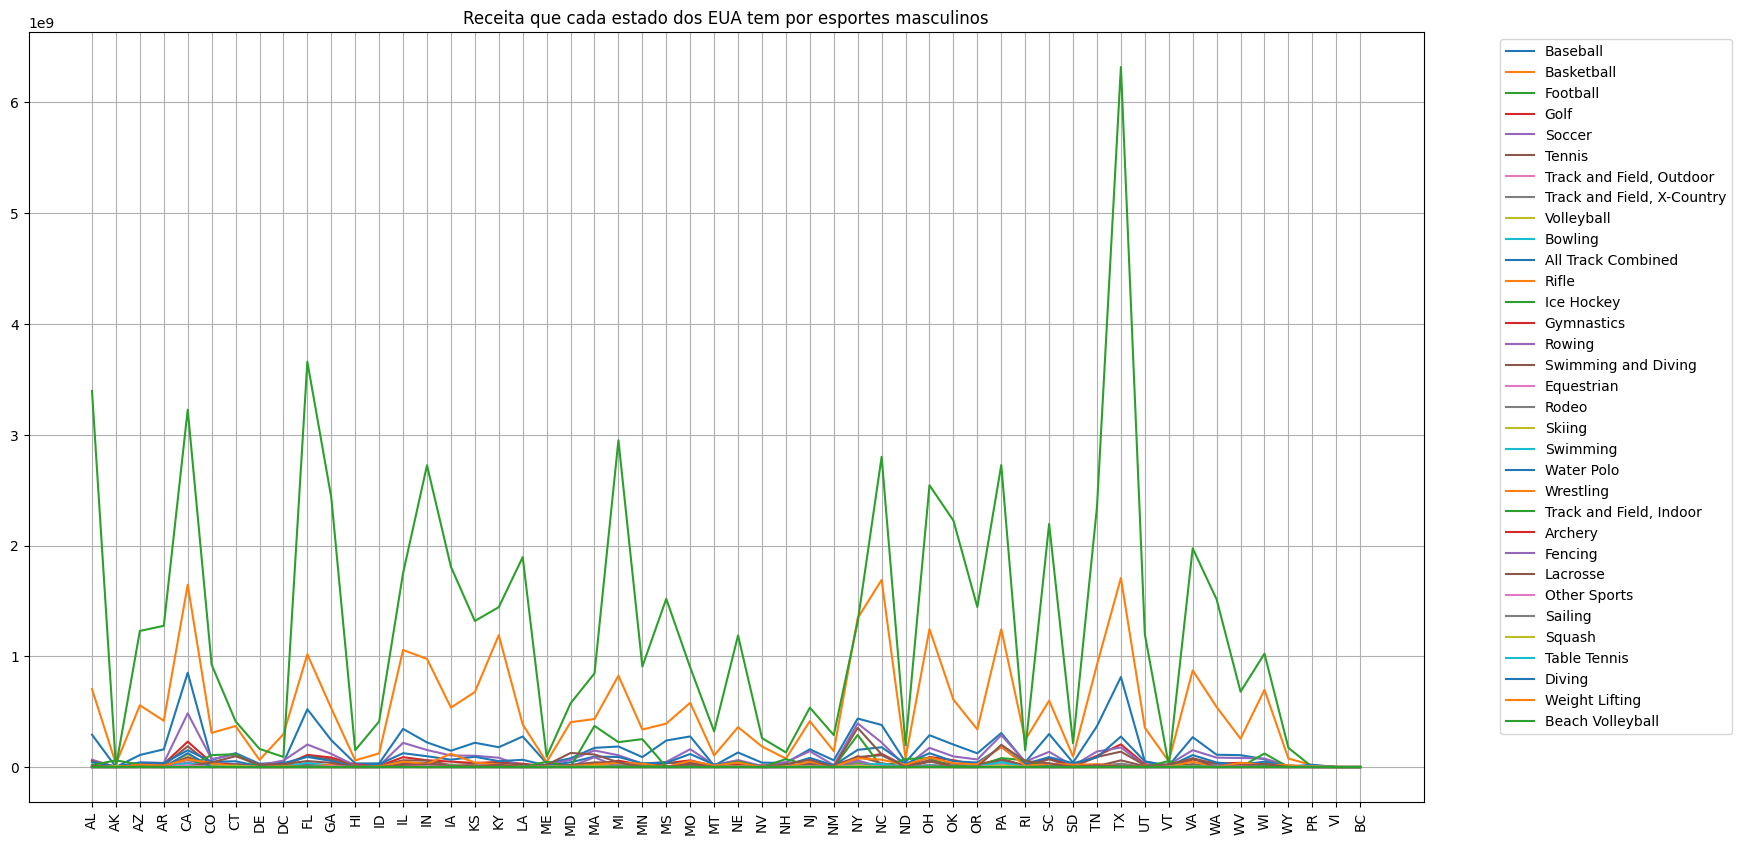

In [70]:
df_men_rev = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_men_rev.columns:
    df_men_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_men_rev.at[state_name, sport_name] += row["REV_MEN"]

nan_value = float("NaN")
df_men_rev.replace(0, nan_value, inplace=True)

df_men_rev.dropna(how='all', axis=1, inplace=True)

df_men_rev.replace(nan_value, 0, inplace=True)

df_men_rev.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Receita que cada estado dos EUA tem por esportes masculinos")

O gráfico acima expõe que o futebol americano (representado pela cura verde mais significativa) é o esporte que mais recebe investimento (muito mais do que os demais esportes), o que era um resultado já esperado, devido ao fato deste ser um dos esportes mais populares e televisionados dos EUA. Em seguida, vemos que o basquete e o baseball (curvas laranja e azul mais significativas) também recebem muito investimento.

Testacamos que o alto investimento que o futebol americano recebe no Texas.

Text(0.5, 1.0, 'Receita que cada estado dos EUA tem por esportes femininos')

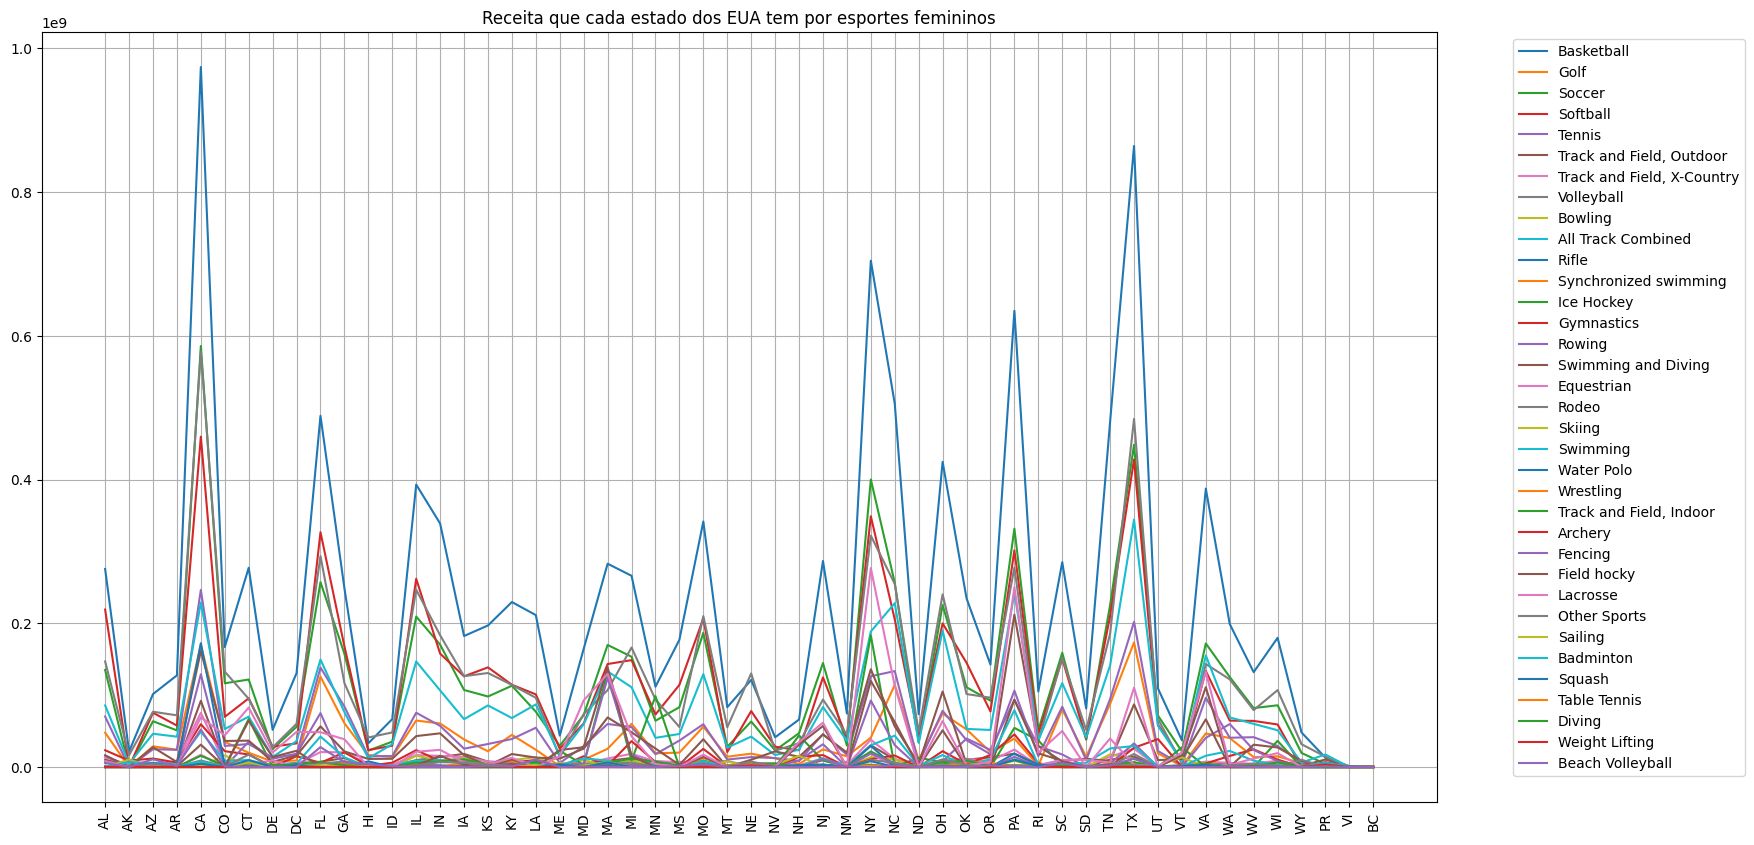

In [71]:
df_women_rev = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_women_rev.columns:
    df_women_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_women_rev.at[state_name, sport_name] += row["REV_WOMEN"]

nan_value = float("NaN")
df_women_rev.replace(0, nan_value, inplace=True)

df_women_rev.dropna(how='all', axis=1, inplace=True)

df_women_rev.replace(nan_value, 0, inplace=True)

df_women_rev.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Receita que cada estado dos EUA tem por esportes femininos")

Já nesse gráfico, percebemos que o futebol americano não recebe muito investimento, devido ao fato de não ser um esporte popularmente praticado entre as mulheres. Contudo, o basquete (curva azul mais significativa) permanece recebendo alto investimento, juntamente com o futebol, o softball e o vôlei (curvas verde, vermelha e marrom, respectivamente).

Destacamos os investimentos realizados nos estados do Texas, Califórnia, Nova York e Flórida, cujas curvas de investimento de destacam muito em relação às outras.

É relevante destacar a diferença dos valores da escala do eixo 'y' em ambos os gráficos. Os valores no gráfico referente ao investimento nas modalidades masculinas é significamente maior do que os das femininas, o que sugere e reforça a realidade desigual de apoio entre homens e mulheres.

Os dois gráficos a seguir apresentam as despesas de cada esporte (nas modalidades masculina e feminina em cada estado) ao longo de todos os anos analisados em cada estado.

Text(0.5, 1.0, 'Despesas que cada estado dos EUA tem por esportes masculinos')

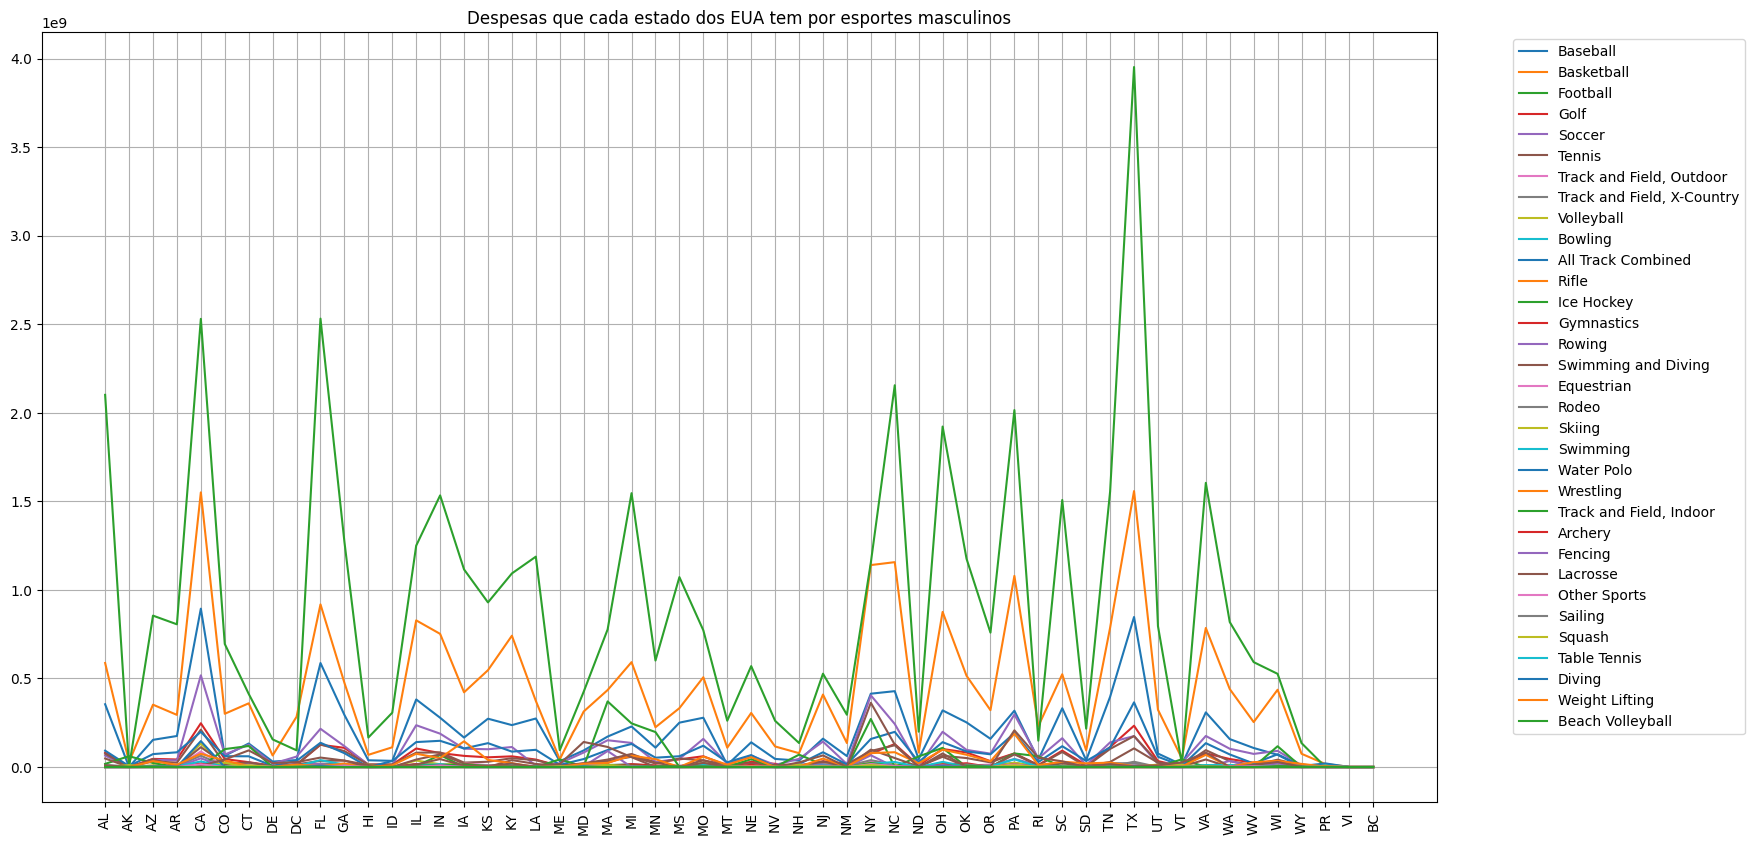

In [72]:
df_men_exp = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_men_exp.columns:
    df_men_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_men_exp.at[state_name, sport_name] += row["EXP_MEN"]

nan_value = float("NaN")
df_men_exp.replace(0, nan_value, inplace=True)

df_men_exp.dropna(how='all', axis=1, inplace=True)

df_men_exp.replace(nan_value, 0, inplace=True)

df_men_exp.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Despesas que cada estado dos EUA tem por esportes masculinos")

No gráfico acima, destacamos a alta despesa no futebol americano no Texas (curva verde mais significativa), que foi o que teve maior receita. Isso pode ser explicado pelo fato de que o alto investimento no esporte alta a probabilidade do melhor desempenho das equipes, o que leva à necessidade de obter equipamentos e serviços mais robustos -- que são caros -- que contribuam para melhorar a atuação e os resultados dos times.

Text(0.5, 1.0, 'Despesas que cada estado dos EUA tem por esportes femininos')

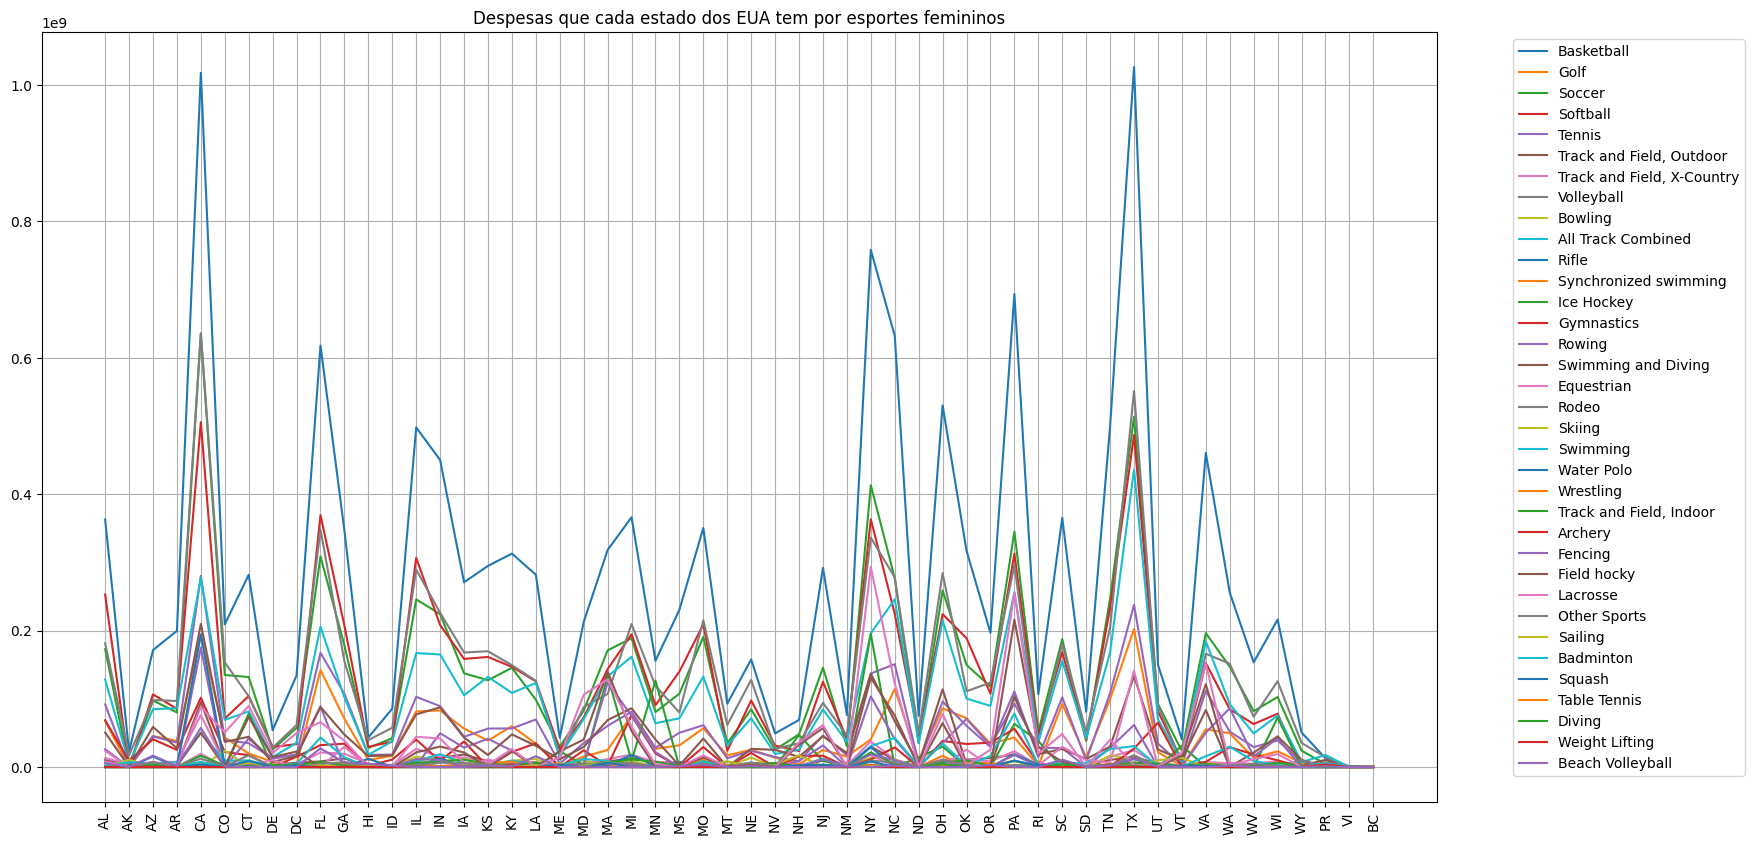

In [73]:
df_women_exp = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_women_exp.columns:
    df_women_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_women_exp.at[state_name, sport_name] += row["EXP_WOMEN"]

nan_value = float("NaN")
df_women_exp.replace(0, nan_value, inplace=True)

df_women_exp.dropna(how='all', axis=1, inplace=True)

df_women_exp.replace(nan_value, 0, inplace=True)

df_women_exp.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Despesas que cada estado dos EUA tem por esportes femininos")

No gráfico acima, destacamos a alta despesa no basquete americano no Texas e na California (curva azul mais significativa), que foi o que teve maior receita em ambos os estamos. A justificativa apresentada no gráfico anterior também é válida nesse caso.

Nos gráficos a seguir, apresentaremos as análises referentes aos lucros obtidos em cada esporte ao longo dos anos em cada estado.

Text(0.5, 1.0, 'Lucro que cada estado dos EUA tem por esportes masculinos')

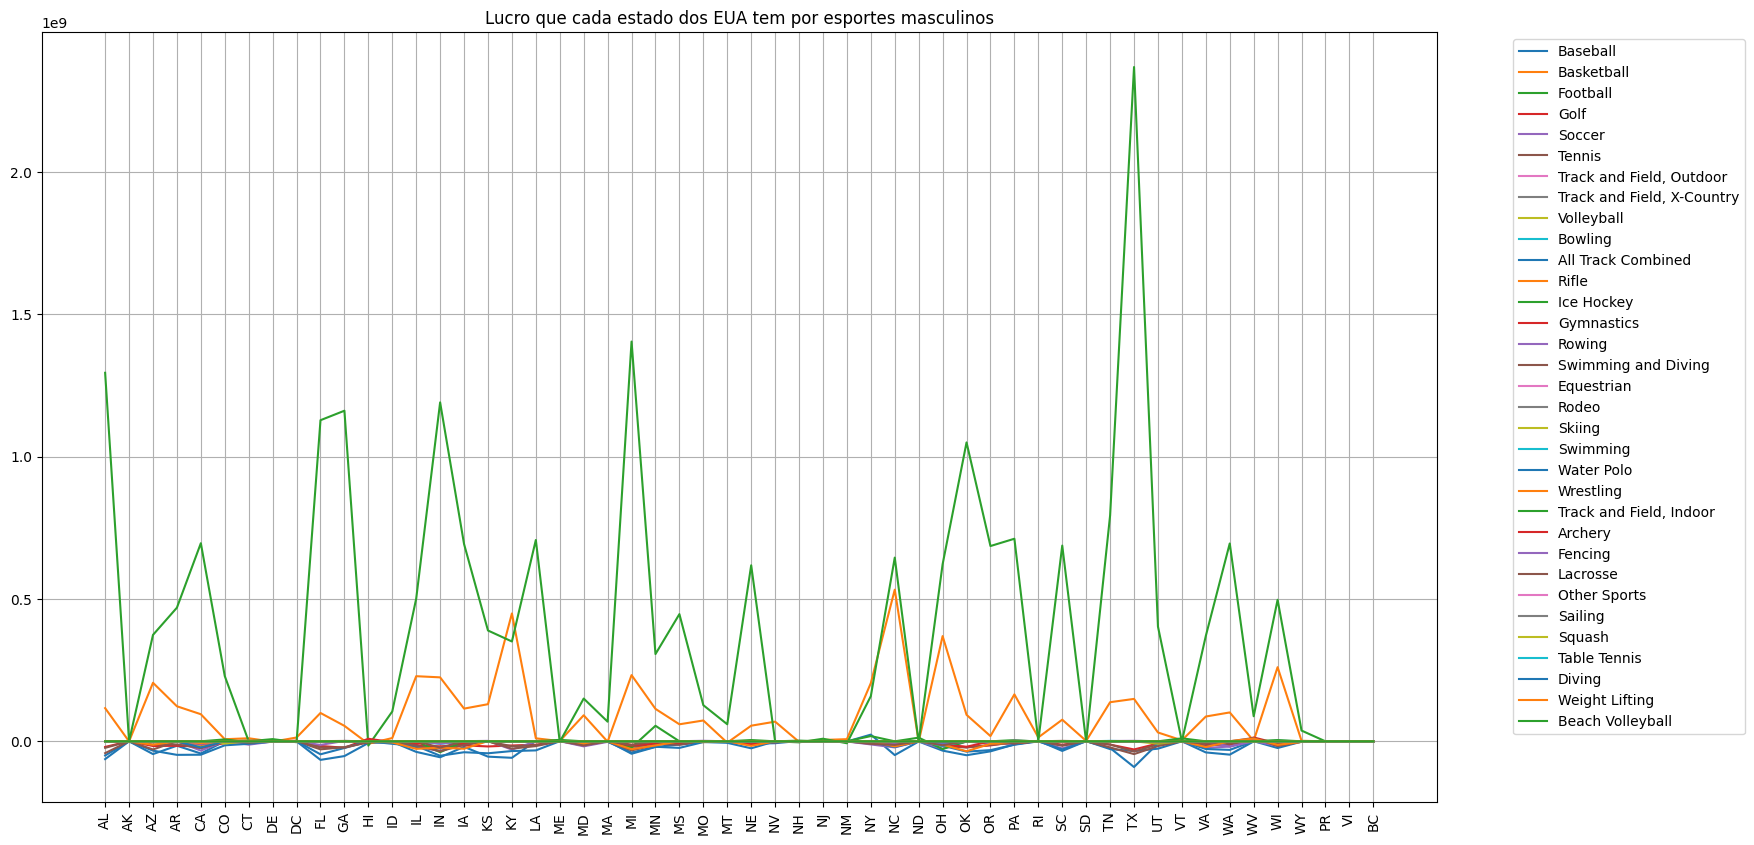

In [74]:
df_men_lucro = df_men_rev - df_men_exp

nan_value = float("NaN")
df_men_lucro.replace(0, nan_value, inplace=True)

df_men_lucro.dropna(how='all', axis=1, inplace=True)

df_men_lucro.replace(nan_value, 0, inplace=True)

df_men_lucro.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro que cada estado dos EUA tem por esportes masculinos")

O gráfico acima revela que o futebol americano é o que tem mais lucro entre os esportes analisados, devido ao fato de ser o mais popular, o que leva à maior procura por eventos por parte dos indivíduos. Vale destacar que há esporte que obtiveram prejuízo ao longo dos anos, mas tal perda não foi tão drástica como nas modalidades femininas, como será apresentado a seguir.

Text(0.5, 1.0, 'Lucro que cada estado dos EUA tem por esportes femininos')

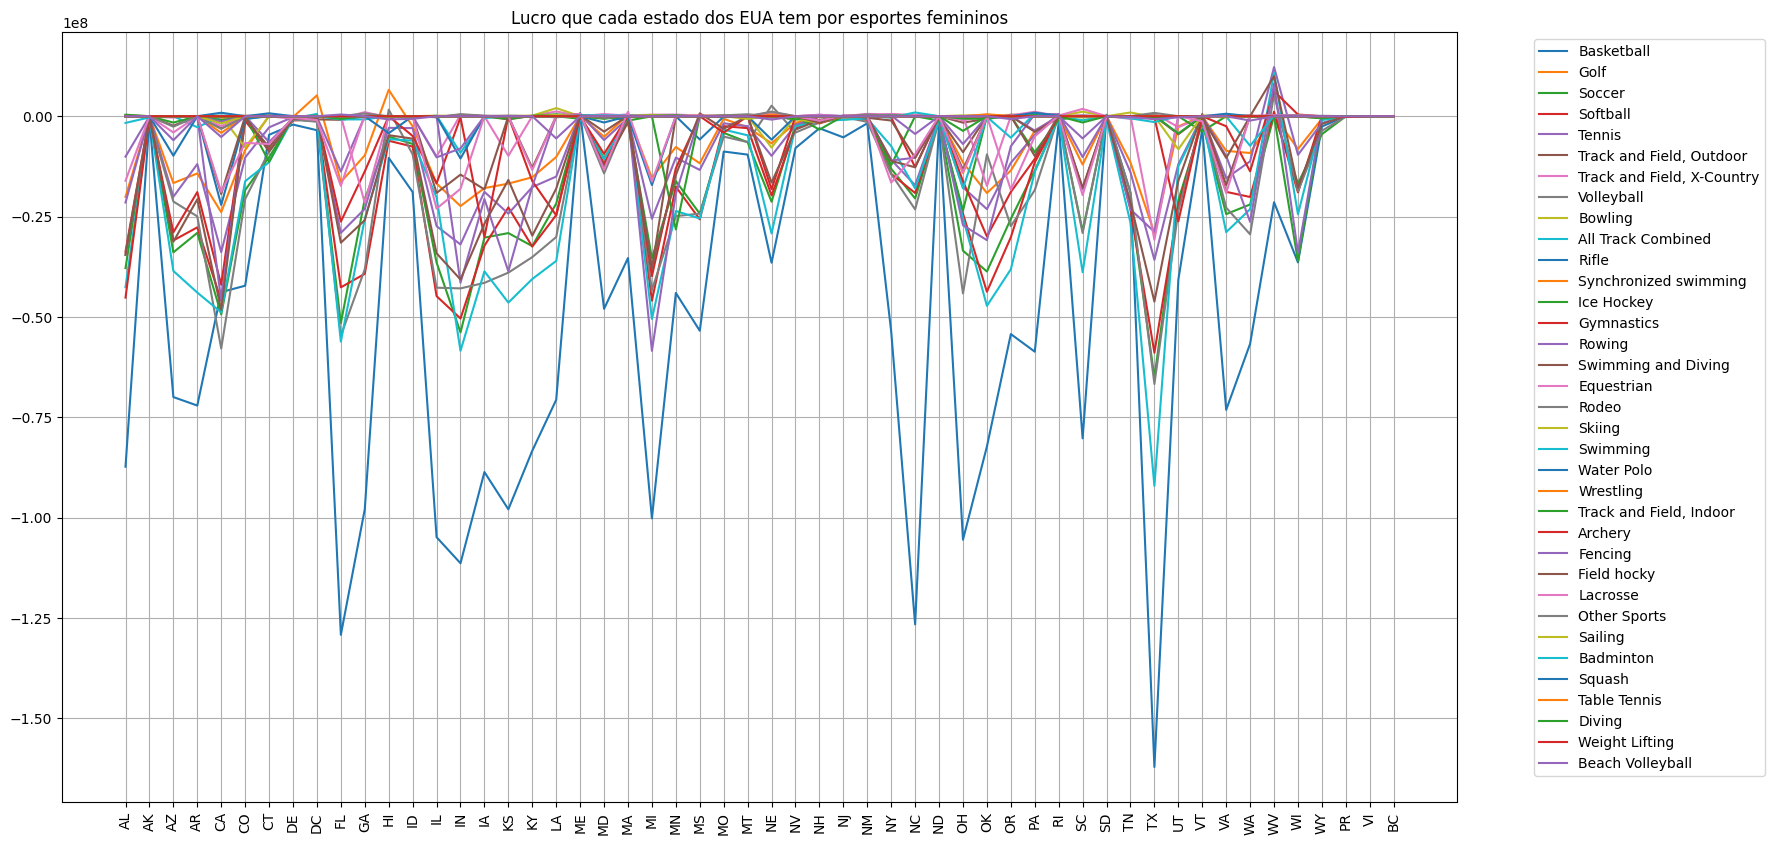

In [75]:
df_women_lucro = df_women_rev - df_women_exp

nan_value = float("NaN")
df_women_lucro.replace(0, nan_value, inplace=True)

df_women_lucro.dropna(how='all', axis=1, inplace=True)

df_women_lucro.replace(nan_value, 0, inplace=True)

df_women_lucro.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro que cada estado dos EUA tem por esportes femininos")

Em contrapartida, destacamos que a maioria dos esportes femininos têm um grande prejuízo (há mais prejuízo do que lucro), o que reflete a realidade de que o baixo investimento feito aos esportes femininos não cobrem os custos para sustentar o esporte e garantir uma boa performace das atletas.

Os dois gráficos a seguir apresentam os intervalos de confiança dos lucros que cada estados têm.

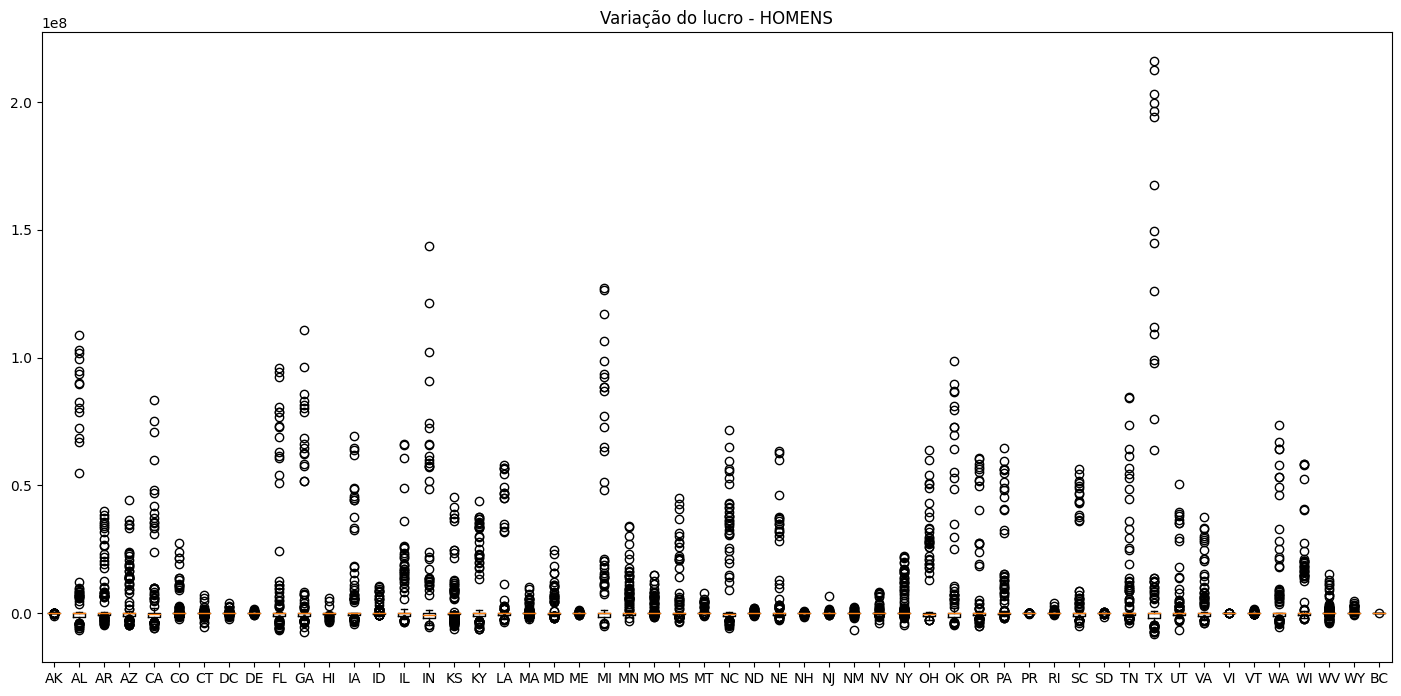

In [76]:
profit_men = {} # estado: {ano: [ [lucro], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in profit_men.keys():
      profit_men[row["state_cd"]] = {}

    if row["YEAR"] not in profit_men[row["state_cd"]].keys():
      profit_men[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["EXP_MEN"] != 0.0 or row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      profit_men[row["state_cd"]][row["YEAR"]][0].append(row["REV_MEN"] - row["EXP_MEN"])
      profit_men[row["state_cd"]][row["YEAR"]][1].append(sport_name)

data = []
for elem in profit_men.values():
  data_state = []
  for arrays in elem.values():
    data_state = data_state + arrays[0]
  data.append(data_state)


fig = plt.figure(figsize =(15, 7))
ax = fig.add_axes([0.06, 0.04, 0.9, 0.9])
bp = ax.boxplot(data)
ax.set_xticklabels(profit_men.keys())
plt.title("Variação do lucro - HOMENS")
plt.show()

Percebemos que, apesar dos outliers, a variação dos lucros é muito baixa, na qual predomina o lucro ser muito próximo de zero. O boxplot revela que, em todos os estados, se um esporte tem um lucro muito grande ou muito pequeno, definitivamente há um evento externo influenciando tal situação (não pode ser explicada pelo acaso).

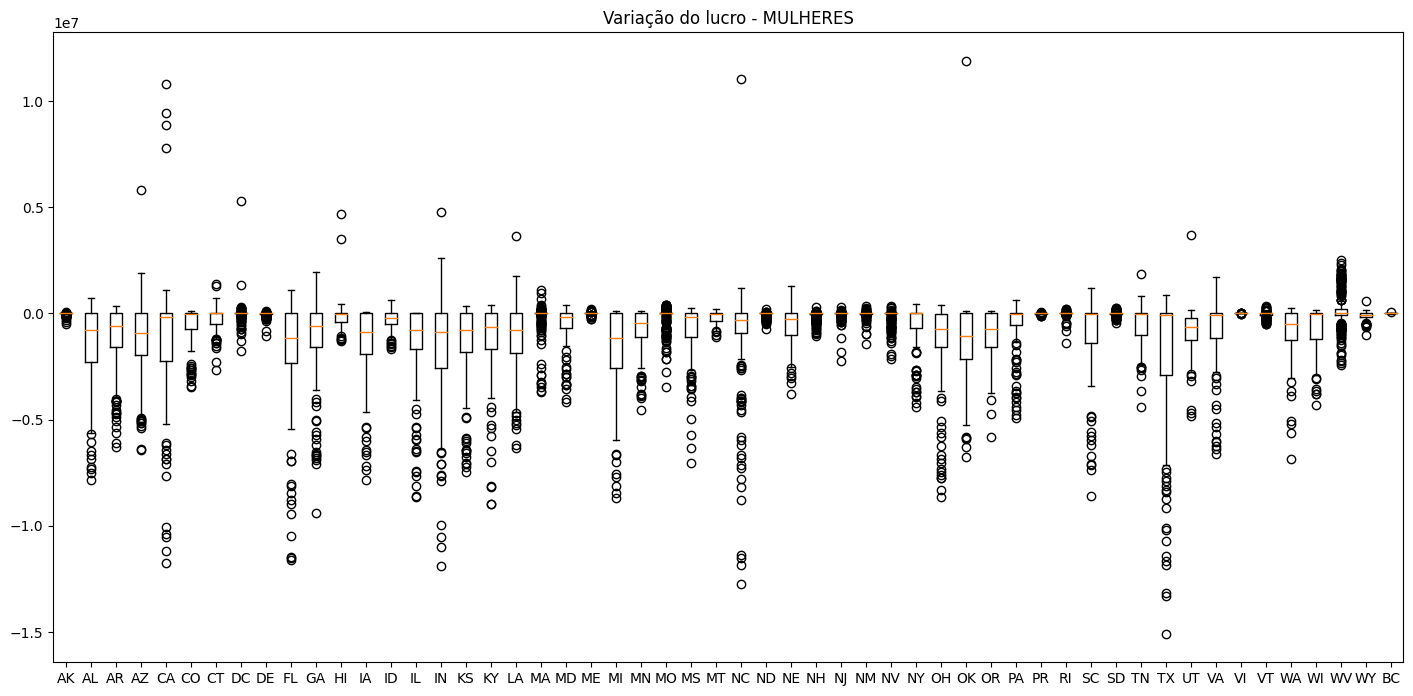

In [77]:
profit_women = {} # estado: {ano: [ [lucro], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in profit_women.keys():
      profit_women[row["state_cd"]] = {}

    if row["YEAR"] not in profit_women[row["state_cd"]].keys():
      profit_women[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["EXP_WOMEN"] != 0.0 or row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      profit_women[row["state_cd"]][row["YEAR"]][0].append(row["REV_WOMEN"] - row["EXP_WOMEN"])
      profit_women[row["state_cd"]][row["YEAR"]][1].append(sport_name)

data = []
for elem in profit_women.values():
  data_state = []
  for arrays in elem.values():
    data_state = data_state + arrays[0]
  data.append(data_state)


fig = plt.figure(figsize =(15, 7))
ax = fig.add_axes([0.06, 0.04, 0.9, 0.9])
bp = ax.boxplot(data)
ax.set_xticklabels(profit_women.keys())
plt.title("Variação do lucro - MULHERES")
plt.show()

Em contrapartida, os intervalos de confiança do lucro que cada estado obtém com os esportes femininos são mais extensos, tendendo a ser negativos -- indicam que o prejuízo pode ser explicado pelo acaso. É sugerido que lucros muito altos são causados por situações externas e não é "comum", bem como prejuízos muito altos.

### Análise do lucro de cada esporte em cada ano

Outra análise que realizamos foi referente ao lucro que cada esporte obteve ao longo dos anos. Realizamos tal análise tendo como maior objetivo investigar o impacto da Pandemia e da Crise de 2008 nos investimentos dos esportes universitários.

Text(0.5, 1.0, 'Lucro por esportes masculinos por ano')

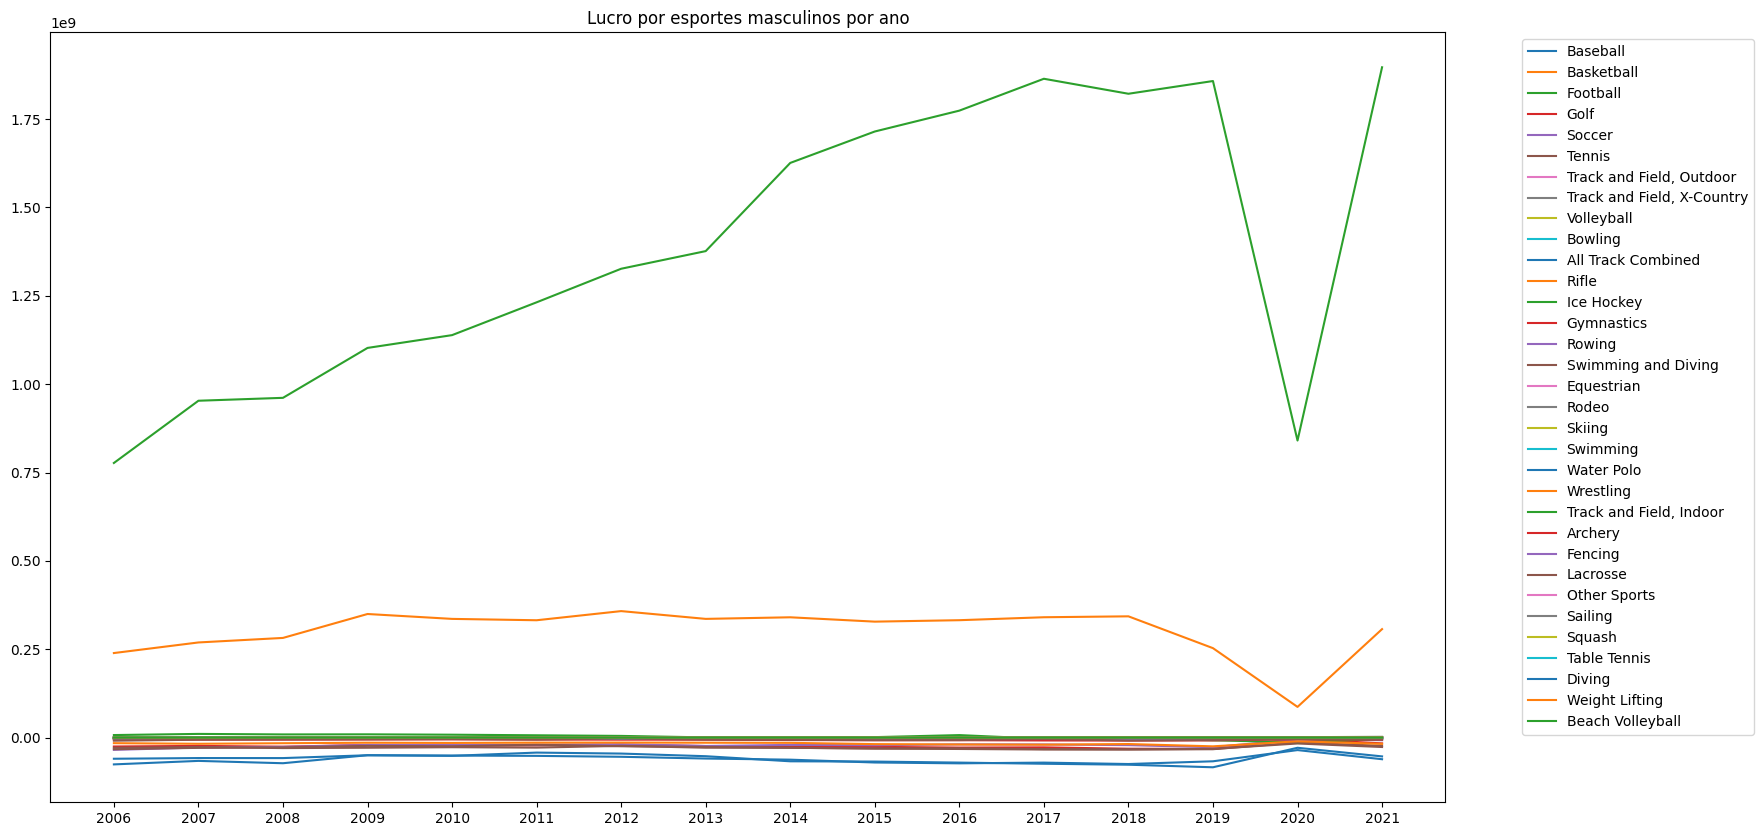

In [78]:
df_men_rev = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_men_rev.columns:
    df_men_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_men_rev.at[year, sport_name] += row["REV_MEN"]

nan_value = float("NaN")
df_men_rev.replace(0, nan_value, inplace=True)

df_men_rev.dropna(how='all', axis=1, inplace=True)

df_men_rev.replace(nan_value, 0, inplace=True)

df_men_exp = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_men_exp.columns:
    df_men_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_men_exp.at[year, sport_name] += row["EXP_MEN"]

nan_value = float("NaN")
df_men_exp.replace(0, nan_value, inplace=True)

df_men_exp.dropna(how='all', axis=1, inplace=True)

df_men_exp.replace(nan_value, 0, inplace=True)

df_lucro = df_men_rev - df_men_exp

df_lucro.plot(figsize=(18,10))
x_values = range(len(years))
plt.xticks(years,fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro por esportes masculinos por ano")

Conforme esperávamos, o ano de 2020 apresentou uma queda nos lucros dos esportes, principalment e do futebol americano (curva verde) e do basquete (curva laranja). Nos demais esportes, não é possível verificar se o lucro diminuiu, devido à constância ao longo dos anos. Nos esportes que não obtiveram esse alto prejuízo nesse período, tal realidade pode ser explicada pelo fato de que, com o lockdown que o passou teve, os gastos que não eram fixos não eram realizados, o que levou ao menor custo nesse ano.

Por outro lado, em 2008, devido à forte crise imobiliária e financeira que os EUA sofreu, não houve impacto significativo no lucro dos esportes universitários.

Text(0.5, 1.0, 'Lucro por esportes femininos por ano')

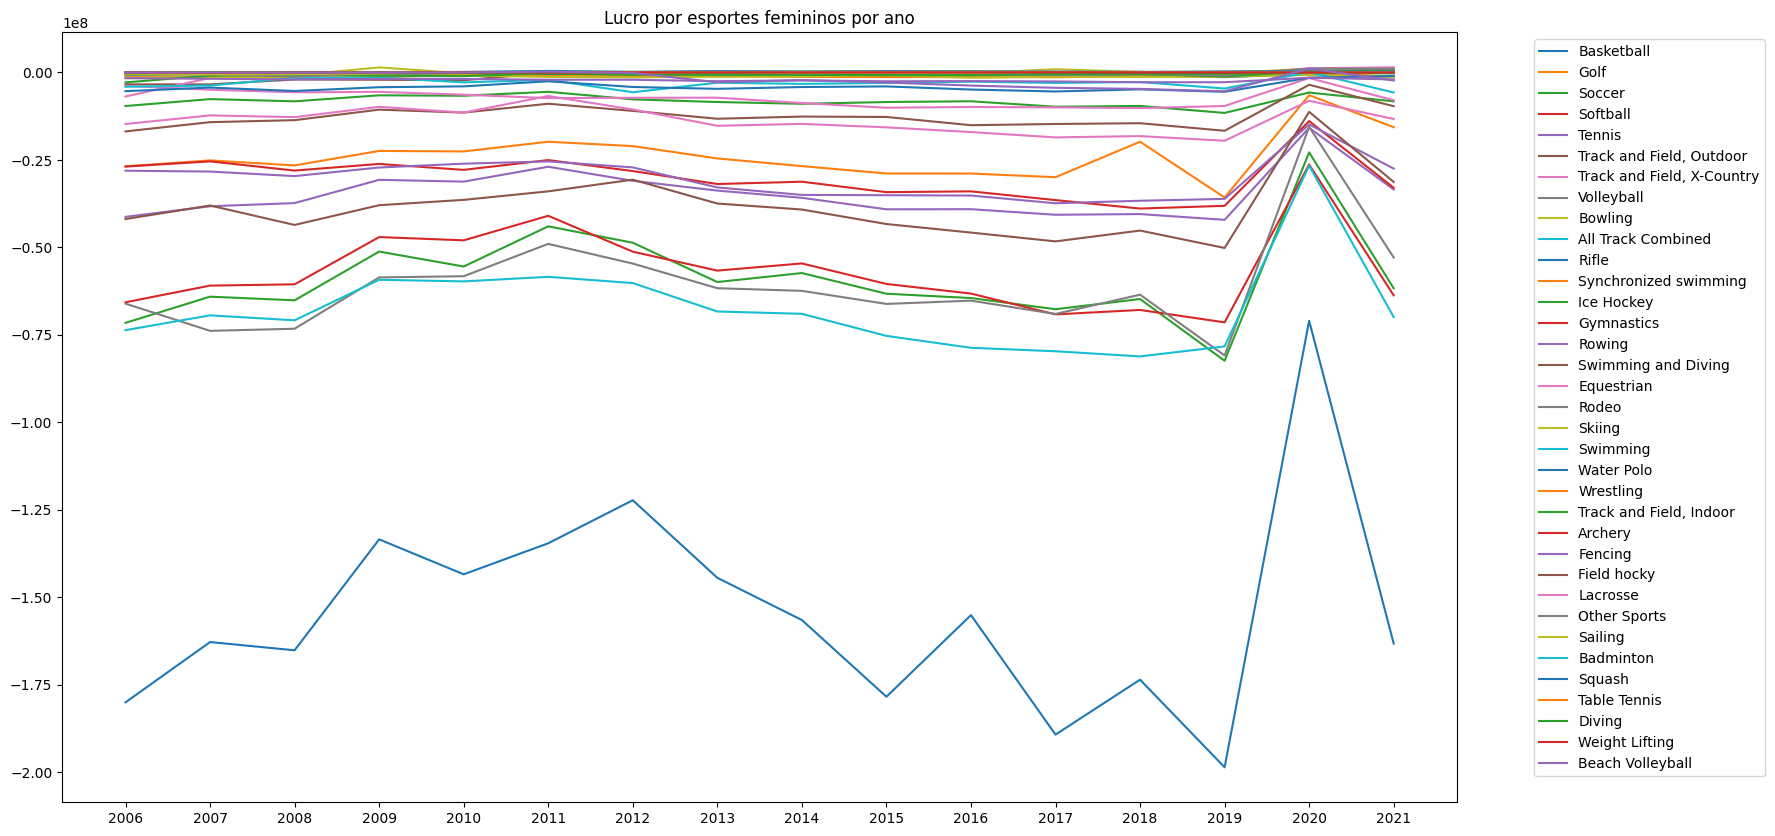

In [79]:
df_women_rev = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_women_rev.columns:
    df_women_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_women_rev.at[year, sport_name] += row["REV_WOMEN"]

nan_value = float("NaN")
df_women_rev.replace(0, nan_value, inplace=True)

df_women_rev.dropna(how='all', axis=1, inplace=True)

df_women_rev.replace(nan_value, 0, inplace=True)

df_women_exp = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_women_exp.columns:
    df_women_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_women_exp.at[year, sport_name] += row["EXP_WOMEN"]

nan_value = float("NaN")
df_women_exp.replace(0, nan_value, inplace=True)

df_women_exp.dropna(how='all', axis=1, inplace=True)

df_women_exp.replace(nan_value, 0, inplace=True)

df_lucro = df_women_rev - df_women_exp

df_lucro.plot(figsize=(18,10))
x_values = range(len(years))
plt.xticks(years,fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro por esportes femininos por ano")

Assim como no gráfico referente ao lucro dos esportes por estado, o prejuízo predomina nos esportes femininos, reforçando que o baixo investimento no esporte feminino perdura ao longo dos anos.

Contudo, o gráfico apresentado acima revela que, em 2020, apesar de a maioria dos esportes terem tido prejuízo, esse prejuízo foi menor em comparação aos anos anteriores, o que foi de encontro com o que esperávamos.

## Classificação

Nessa análise apresentada a seguir, tivemos o objetivo de analisar se é possível, dado o número de participantes no esporte, o lucro desse esporte e qual esporte é, classificar a qual estado se refere.

Realizamos essa análise somente sobre os estados da Califórnia, do Texas, de Nova York e da Flórida. Tomamos essa decisão de projeto, pois, inicialmente, ao tentar realizar a classificação proposta anteriormente sobre todos os estados, obtivemos um resultado muito ruim, com o R2 negativo. Portanto, decidimos fazer tal análise apenas com esses 4 estados citados, que foram os que apresentaram curvas mais significativas em todas as análises exploratórias realizadas anteriormente.

(-2.0, 9.0)

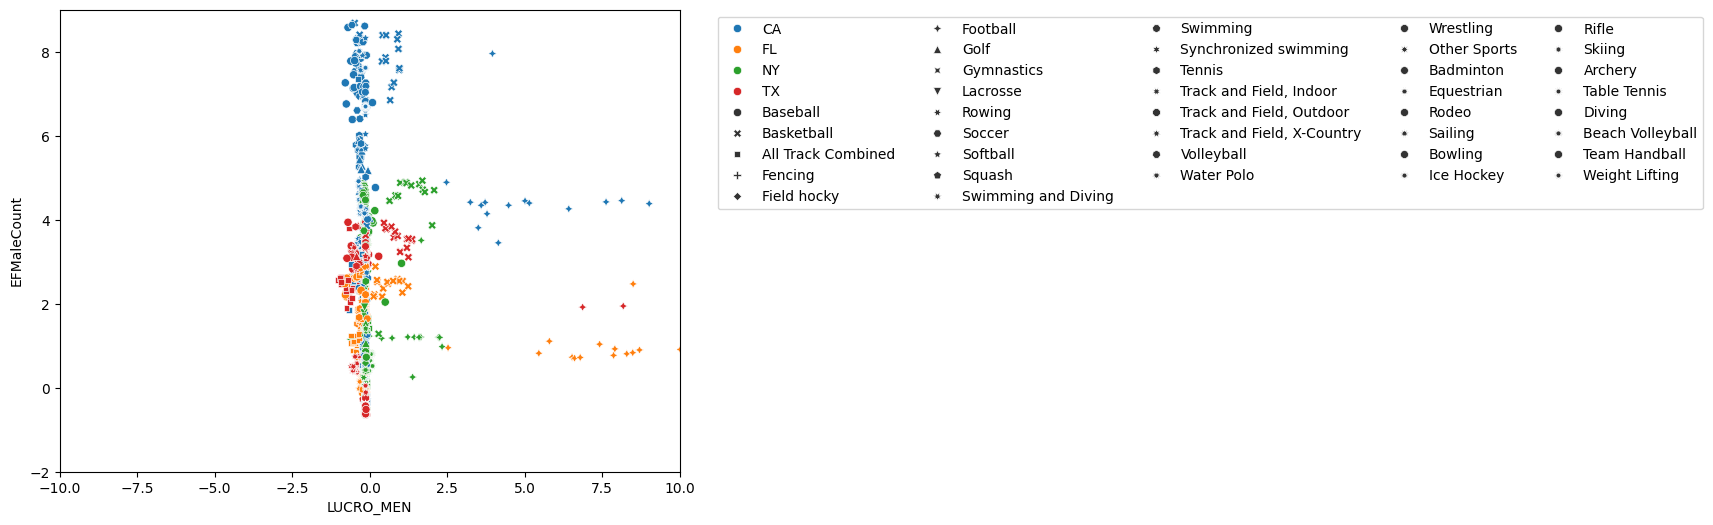

In [80]:
estados_dict = {}
i = 0

for estado in estados:
  estados_dict[estado] = i
  i += 1

znormed = df_filtered[['LUCRO_MEN', 'EFMaleCount']].copy()
znormed = (znormed - znormed.mean()) / znormed.std(ddof=1)
znormed["states"] = df_filtered['state_cd']
znormed["sport"] = df_filtered['SPORTSCODE']

sports_list = []

df_aux1 = znormed.loc[(znormed['states'] == 'TX') | (znormed['states'] == 'CA') | (znormed['states'] == 'NY') | (znormed['states'] == 'FL')]

for index, row in df_aux1.iterrows():
  sports_list.append(sorted_dict[row.loc['sport']])

X = df_aux1["LUCRO_MEN"].values
y = df_aux1["EFMaleCount"].values

sns.scatterplot(data=df_aux1, x='LUCRO_MEN', y='EFMaleCount', hue=df_aux1['states'], palette="tab10", style=sports_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=5)
plt.xlim(-10, 10)
plt.ylim(-2, 9)

No gráfico acima, referente aos esportes masculinos, analisamos a relação entre o lucro que um esporte tem e o número de participantes da modalidade referente. Fica evidente que o lucro nos esportes masculinos se concentram perto de zero, tendo uma variação muito baixa.

Percebemos também que, na Califórnia, a participação é maior do que nos outros estados, formando um cluster mais bem definido, enquanto, nos outros estados, as participações em cada esporte se sobrepõe, sem poder inferir conclusões que destaquem características quanto ao investimento em cada estado.

In [81]:
from sklearn.neighbors import KNeighborsClassifier

y_l = []

for e in df_aux1['states']:
  y_l.append(estados_dict[e])

y = pd.DataFrame(y_l, columns=['States'])
X = df_aux1[['EFMaleCount', 'LUCRO_MEN', 'sport']]

# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# Treino
kf = KFold(n_splits=5) # KFold: faz a permutação, para garantir que os dados do teste não são enviesados
accuracy_iter2 = []

for train_index, val_index in kf.split(X_train, y_train):
    X_tt = X_train.iloc[train_index]
    y_tt = y_train.iloc[train_index]
    X_v = X_train.iloc[val_index]
    y_v = y_train.iloc[val_index]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_tt, y_tt)
    y_pred = knn.predict(X_v)

    accuracy_iter2.append(accuracy_score(y_v, y_pred))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

data_iter = []
data_iter.append(accuracy_iter2)

Accuracy: 0.8415094339622642


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

O código acima implementa a classificação por KNN, usando k = 5 (usamos esse número de vizinhos pois foi o que deu um melhor resultado). Analisamos o valor da acurária que foi obtido (igual a 0.8415). A sobreposição dos pontos, principalmente dos estados do Texas, da Flórida e de Nova York, são os principais contribuintes que impediram que a classificação fosse melhor do que isso.

(-2.0, 9.0)

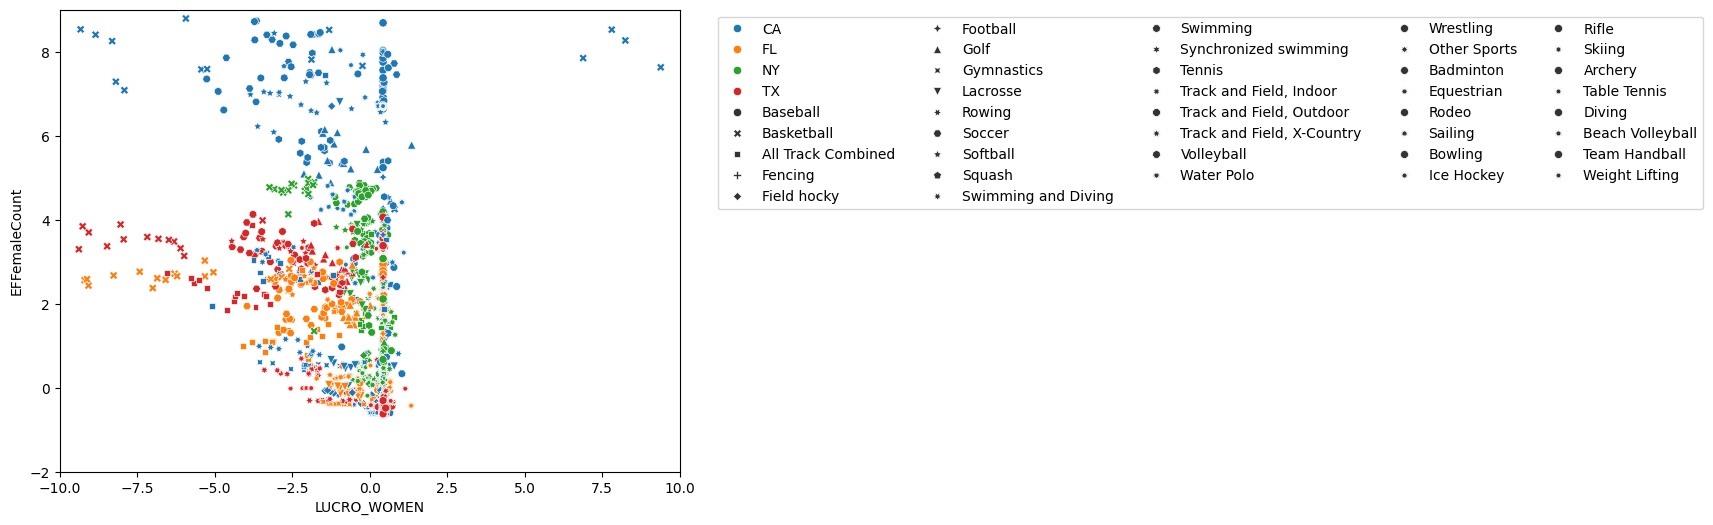

In [82]:
estados_dict = {}
i = 0

for estado in estados:
  estados_dict[estado] = i
  i += 1

znormed = df_filtered[['LUCRO_WOMEN', 'EFFemaleCount']].copy()
znormed = (znormed - znormed.mean()) / znormed.std(ddof=1)
znormed["states"] = df_filtered['state_cd']
znormed["sport"] = df_filtered['SPORTSCODE']
df_aux1 = znormed.loc[(znormed['states'] == 'TX') | (znormed['states'] == 'CA') | (znormed['states'] == 'NY') | (znormed['states'] == 'FL')]

X = df_aux1["LUCRO_WOMEN"].values
y = df_aux1["EFFemaleCount"].values

sports_list = []

for index, row in df_aux1.iterrows():
  sports_list.append(sorted_dict[row.loc['sport']])

sns.scatterplot(data=df_aux1, x='LUCRO_WOMEN', y='EFFemaleCount', hue=df_aux1['states'], palette="tab10", style=sports_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=5)
plt.xlim(-10, 10)
plt.ylim(-2, 9)

O gráfico apresentado acima apresenta mostra a relação entre o lucro que cada esporte tem e o número de mulheres participantes. Percebemos uma grande concentração quando o lucro é zero, mas que, ainda sim, há uma grande variação.

Além disso, percebemos que, na Califórnia, há mais mulheres participando dos esportes do que nos outros estado, mesmo quando o prejuízo é muito alto, formando um cluster melhor delimitado. Já nos outros estados, os clusters se sobrepõe de maneira significativa.

É revelado que Nova York é o estado (dentre os 4 apresentados) que apresenta menor prejuízo, mas tem participação muito semelhante aos esportes da Flórida e do Texas.

In [83]:
y_l = []

for e in df_aux1['states']:
  y_l.append(estados_dict[e])

y = pd.DataFrame(y_l, columns=['States'])
X = df_aux1[['EFFemaleCount', 'LUCRO_WOMEN', 'sport']]

# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# Treino
kf = KFold(n_splits=7) # KFold: faz a permutação, para garantir que os dados do teste não são enviesados
accuracy_iter = []

for train_index, val_index in kf.split(X_train, y_train):
    X_tt = X_train.iloc[train_index]
    y_tt = y_train.iloc[train_index]
    X_v = X_train.iloc[val_index]
    y_v = y_train.iloc[val_index]

    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_tt, y_tt)
    y_pred = knn.predict(X_v)

    accuracy_iter.append(accuracy_score(y_v, y_pred))

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

data_iter.append(accuracy_iter)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Accuracy: 0.7584905660377359


No código acima é implementado o algoritmo de classificação por KNN. Escolhemos k = 7, pois, durante o desenvolvimento dessa tarefa, a classificação usando esse número de vizinhos foi o que gerou o melhor resultado (que é apresentado acima).

Para realizar a classificação, realizamos KFold, para realizar um treinamento mais eficiente e impedir que houvesse algum "viés" no aprendizado. Além disso, para garantir tal objetivo, também implementamos a validação cruzada.

A métrica acurácia foi calculada e apresentada (é igual a 0.766). Percebemos que essa métrica foi menor do que a classificação realizada com os esportes masculinos. Isso pode ser explicado pelo fato do lucro nos exportes femininos variarem mais do que nos masculinos, o que dificulta no processo de classificação.

[Text(1, 0, 'Acurária Homem'), Text(2, 0, 'Acurácia Mulher')]

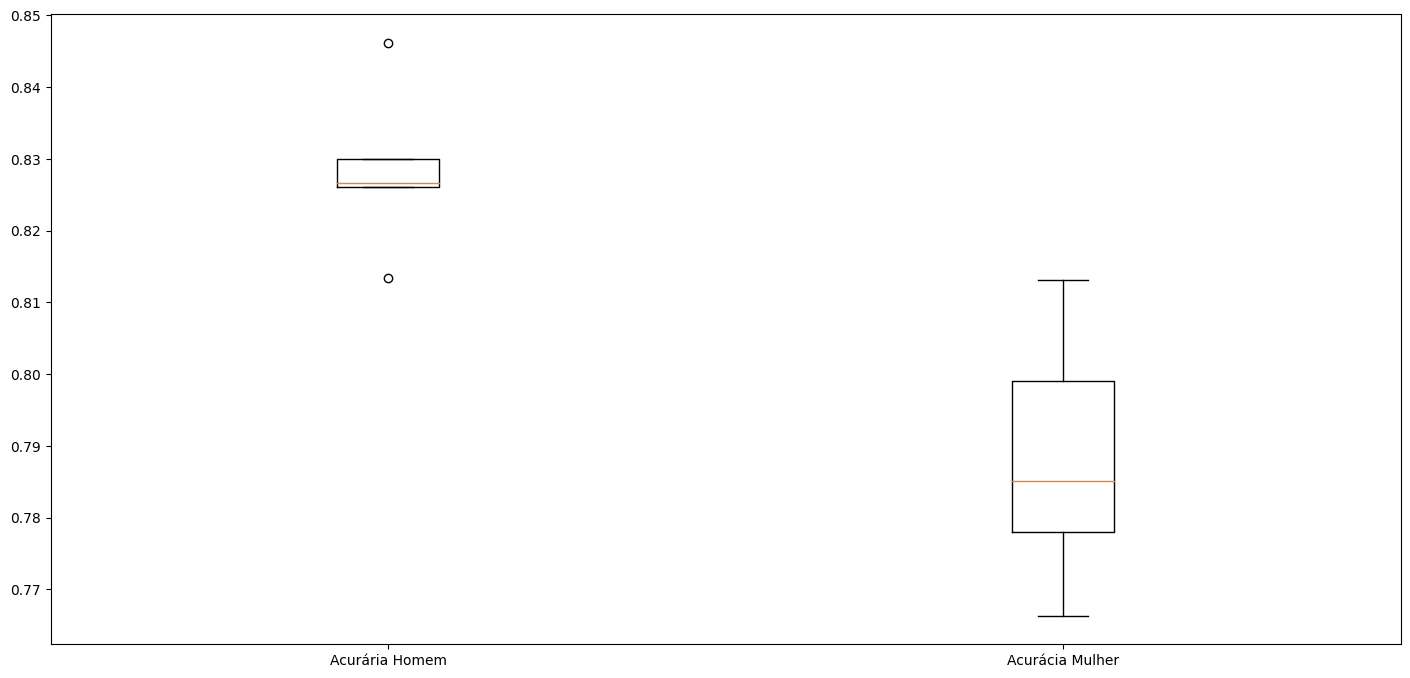

In [84]:
fig = plt.figure(figsize =(15, 7))
ax = fig.add_axes([0.06, 0.04, 0.9, 0.9])
bp = ax.boxplot(data_iter)
ax.set_xticklabels(["Acurária Homem", "Acurácia Mulher"])

O boxplot apresentado acima revela que o valor da acurácia na classificação dos esportes femininos varia mais do que a acurácia da classificação dos esportes masculinos. Isso pode ser explicado pelo fato da variação do lucro variar muito entre as categorias femininas, com ocorrências de muitos estados terem prejuízo muito alto (como foi discutido no boxplot plotado anteriormente na análise dessa pergunta), enquanto, nas categorias masculinas, o lucro se concentrar mais no zero (também pode ser visto no boxplot referente ao lucro de esportes masculinos por estado), com poucos casos que destoam muito disso.

# Pergunta 3: Quais são os estados com as maiores e as menores taxas de participação de mulheres nos esportes?

Motivados por esta pergunta, buscamos analisar os dados das instituições educacionais presentes nos Estados Unidos para, assim, analisar se existe uma diferença concreta entre homens e mulheres na participação dos esportes e, caso exista, descobrir se existe uma diferença desta taxa de participação das mulheres nos esportes entre os diferentes estados.

## Análise Exploratória

### Plotando gráfico da diferença da participação das mulheres nos esportes nos estados

In [85]:
# Função que corrige a escala e a rotação do mapa a ser plotado
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

# Função que corrige a posição do alaska e do Hawaii para facilitar a visualização
def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

In [86]:
# Função que realiza a plotagem do gráfico
def plot_porcentagem(gdf):
  gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
  gdf['coords'] = [coords[0] for coords in gdf['coords']]

  gdf = gdf.drop_duplicates()
  map = gdf[['geometry', 'Porcentagem_Mulheres', 'STUSPS', 'NAME', 'coords']]

  f, ax = plt.subplots()
  f.set_size_inches(20, 18)

  map.plot(
      ax=ax,
      column='Porcentagem_Mulheres',
      cmap='Oranges',
      edgecolor="black",
      linewidth=0.4,
      missing_kwds={
          "color": "lightgrey",
          "edgecolor": "black",
          "label": "Missing values",
      },
  )

  texts = []

  for idx, row in map.iterrows():
      texts.append(ax.text(row.coords[0], row.coords[1], s=row['NAME'], horizontalalignment='center',))

  sm = plt.cm.ScalarMappable(
      cmap="Oranges",
      norm=plt.Normalize(
          vmin= 0,
          vmax=map["Porcentagem_Mulheres"].max(),
      ),
  )

  cax = f.add_axes(
      [
          0.9,
          0.3,
          0.03,
          0.40,
      ]
  )

  ax.set_title(f'Porcentagem de participação das mulheres nos esportes nos estados', fontdict={"fontsize": 16})
  ax.axis('off')


  f.colorbar(sm, cax=cax)
  plt.show()

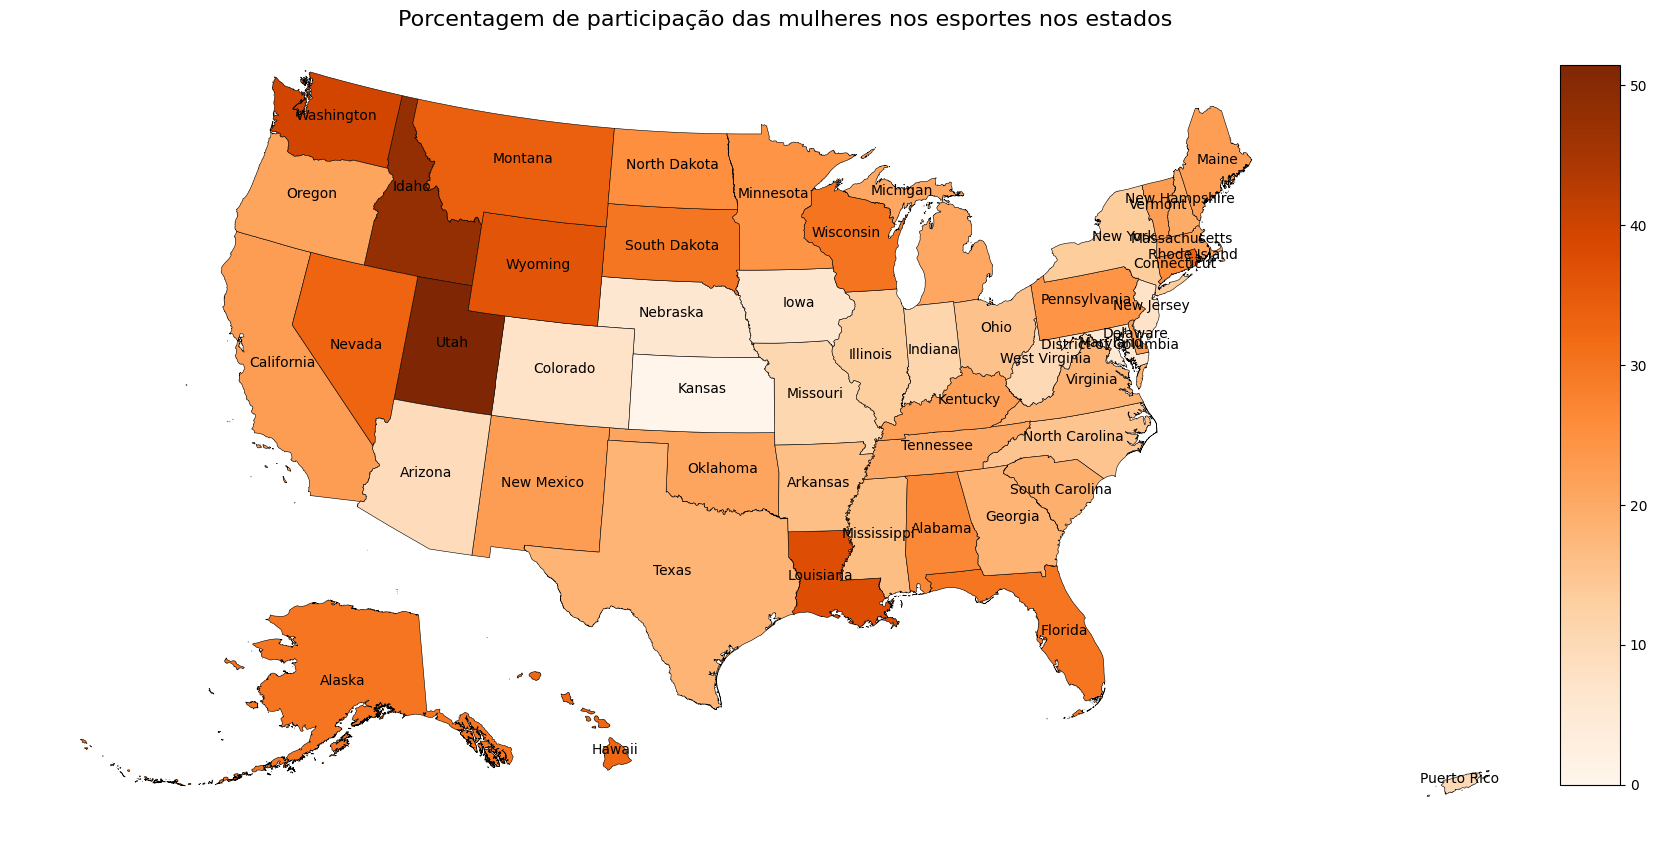

In [100]:
# Importanto dados relacionados ao formato dos Estados Unidos
states_3 = geopandas.read_file('https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/Dados_Shapes_USA/cb_2018_us_state_500k.shp')
states_3 = states_3[~states_3.STATEFP.isin(["60", "66", "69", "78"])] # Retira territórios que não são do interesse de análise
states_3 = states_3.to_crs("ESRI:102003") # Corrige a projeção territorial
states_3 = adjust_maps(states_3)
gdf_3 = states_3.merge(diff_states_plot,left_on='STUSPS',right_on='state_cd')

# Realizando plot
plot_porcentagem(gdf_3)

O gráfico acima nos mostra que a taxa de participaçao das mulheres nos esportes varia muito entre os estados, sendo que, estados como Utah e Idaho possuem as maiores taxas de participação e estados como Kansas e Maryland possuem as menores taxas.

### Plotando porcentagem de participação das mulheres nos esportes ao longo dos anos em 10 estados diferentes

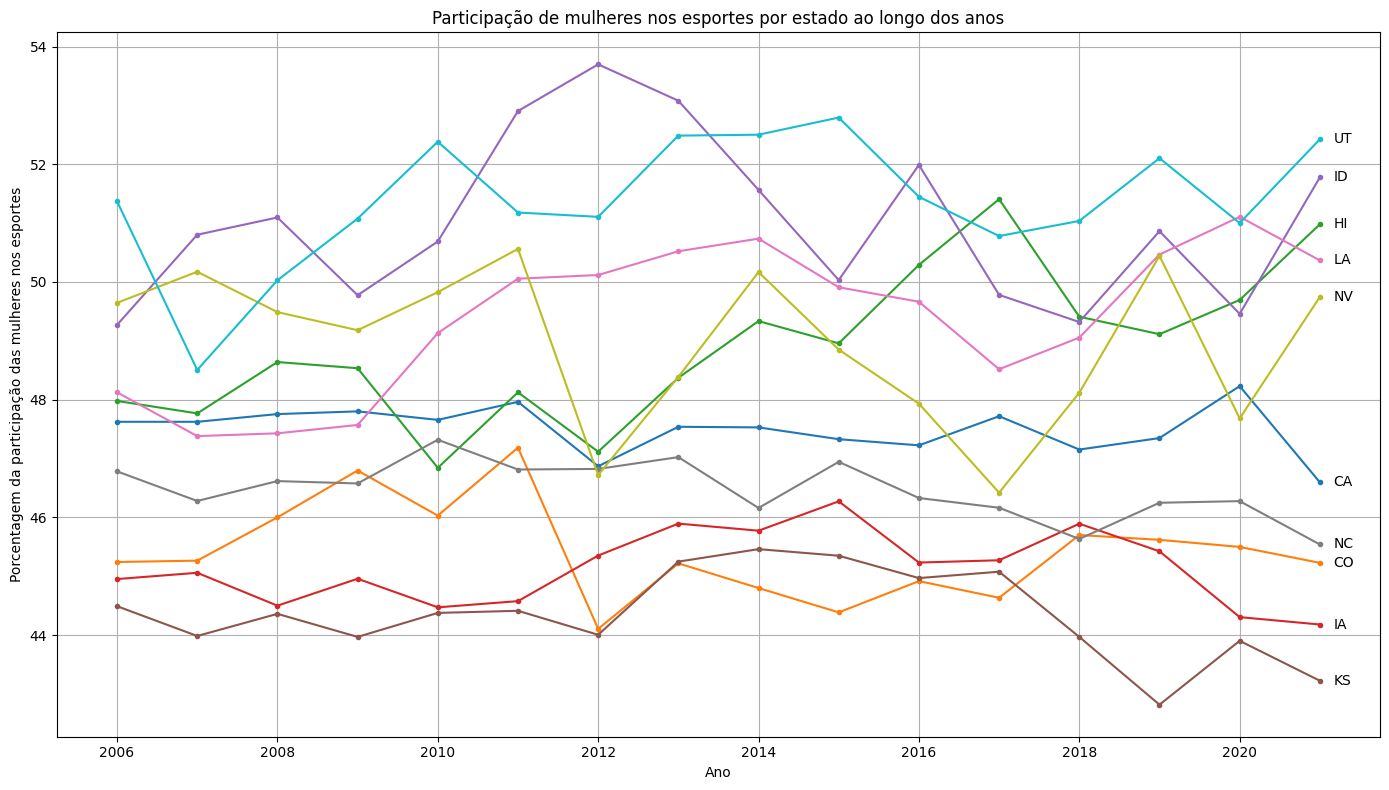

In [101]:
estados = states_time_3.groupby('state_cd')

fig, ax = plt.subplots(figsize=(14, 8))
for estado, info in estados:
    ax.plot(info['YEAR'], info['Porcentagem_Mulheres'], marker='.', linestyle='-', label=estado)
    ultimo_participantes = info.iloc[-1]['Porcentagem_Mulheres']
    ax.annotate(estado, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center')

ax.set_xlabel('Ano')
ax.set_ylabel('Porcentagem da participação das mulheres nos esportes')
ax.set_title('Participação de mulheres nos esportes por estado ao longo dos anos')

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

## Teste de Hipótese

Dado a diferença entre as taxas de participação das mulheres nos esportes nos estados, é relevante analisarmos se essas diferenças observadas são geradas pelo acaso ou existe um fator concreto que as determina.

Com isso em mente, buscamos analinar os estados Kansas (estado com maior taxa de participação das mulheres nos esportes) e Utah (estado com menor taxa de participação das mulheres nos esportes).

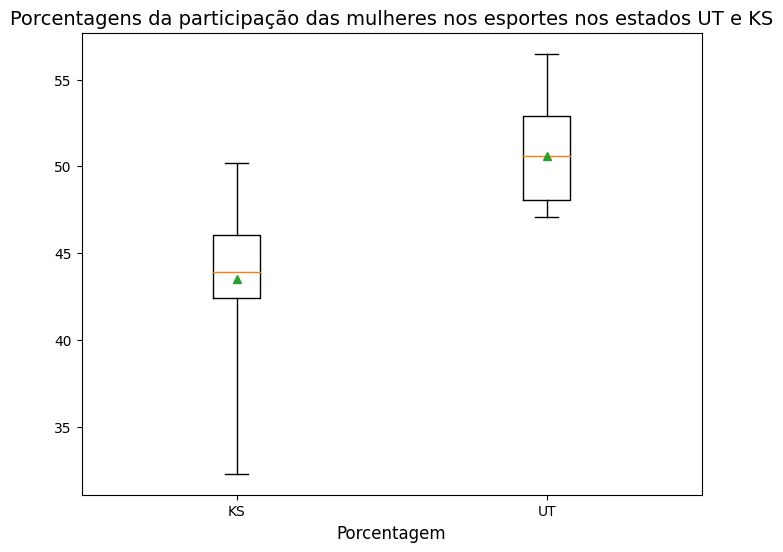

In [102]:
# Analisando diferenças no intervalo de porcentagens de participaçao de mulheres nos esportes nos
# estados com as maiores e as menores dessas porcentagens (Estados KS e UT)

states_hip_3 = [KS, UT]

plt.rcParams['figure.figsize']  = (8, 6)
plt.boxplot(states_hip_3, whis=[2.5, 97.5], positions=[1,2], showfliers=False, showmeans=True)
plt.xticks([1,2], ['KS', 'UT'], fontsize=10)
plt.ylabel('', fontsize=13)
plt.xlabel('Porcentagem', fontsize=12)
plt.title('Porcentagens da participação das mulheres nos esportes nos estados UT e KS', fontsize=14)
plt.show()

Analisando os Boxplots acima, nos é dado uma pista de que existe uma diferença real (não gerada pelo acaso) na diferença das taxas de participação de homens e mulheres entre os estados do Kansas e Utah. Percebemos isto pelo fato de os intervalos limitados pelos percentís dos Boxplots não conterem uma intercessão.

Motivados por isso, modelamos o seguinte teste de hipótese:

- Hipótese Nula: Diferença na porcentagem de participação das mulheres nos Estados é explicada pelo acaso
- Hipótese Alternativa: Diferença na porcentagem de participação das mulheres nos Estados não é explicada pelo acaso

E, para realizar o teste de hipótese modelado acima, realizamos um teste de permutação.

Text(0, 0.5, 'Frequência')

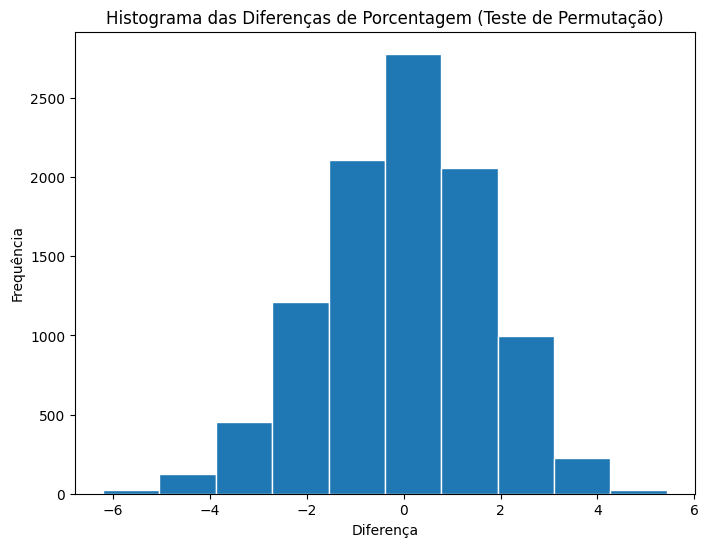

In [103]:
# Realizando Teste de Permutação
simulations = 10000
diffs = np.zeros(simulations)
for i in range(simulations):
  sample = perm_3
  sample['state_cd'] = np.random.permutation(sample['state_cd'].values)
  sample = sample.groupby(['state_cd'])[['Porcentagem_Mulheres']].mean()
  KS = sample.query("state_cd == 'KS'")
  KS = KS['Porcentagem_Mulheres']
  UT = sample.query("state_cd == 'UT'")
  UT = UT['Porcentagem_Mulheres']
  diffs[i] = (UT.iloc[0] - KS.iloc[0])

# Plotando Histograma
plt.hist(diffs,edgecolor='w')
plt.title('Histograma das Diferenças de Porcentagem (Teste de Permutação)')
plt.xlabel('Diferença')
plt.ylabel('Frequência')

Como as diferenças mostradas no histograma construído a partir do teste de permutação são muito distintas da diferença observada (sendo que, inclusive, a diferença entre as taxas de participação mais frequente é zero), podemos perceber que há uma relação real entre as variáveis e rejeitamos a hipótese nula.

## Regressão

Motivados pela existencia de uma real diferença entre as taxas de participação das mulheres nos esportes em diferentes estados, foi realizado uma regressão logística com o intuito de, com base em dados de 3 estados diferentes, realizar uma classificação.

Após realizar o tratamento dos dados (Normalização e encoding dos dados categóricos), realizamos o treino do modelo utilizando KFold com 3 splits para a validação. Os dados de validação, teste e a matriz de confusão estão mostrados abaixo.

In [104]:
# Separando dados
X = reg_log_3.drop('state_cd', axis=1)
Y = reg_log_3[['state_cd']]
X = X[['EFMaleCount','EFFemaleCount','PARTIC_WOMEN','PARTIC_MEN','OPEXPPERPART_MEN','OPEXPPERPART_WOMEN','OPEXPPERTEAM_WOMEN','EXP_MEN','EXP_WOMEN']]

# Encoding da variavel Y
OE = OrdinalEncoder()
Y = OE.fit_transform(Y)

# Normalizando dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Separando entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,random_state=42)

# KFold
kf = KFold(n_splits=3)

In [105]:
# Treino com KFold
log_reg = LogisticRegression(fit_intercept=True,class_weight='balanced')

counter = 0
print("Validação: \n")
for train_index, val_index in kf.split(X_train,y_train):
  X_tt = X_train[train_index]
  X_v = X_train[val_index]
  y_tt = y_train[train_index]
  y_v = y_train[val_index]
  y_tt = y_tt.ravel()

  log_reg.fit(X_tt,y_tt)
  y_pred = log_reg.predict(X_v)
  counter = counter + 1
  print(f"Fold {counter}:")
  print(f"Accuracy = {accuracy_score(y_v,y_pred)}")
  print(f"Precision = {precision_score(y_v,y_pred,average='micro')}")
  print(f"Recall = {recall_score(y_v,y_pred,average='micro')}")
  print(f"F1_score = {f1_score(y_v,y_pred,average='micro')}")
  print("\n")

Validação: 

Fold 1:
Accuracy = 0.6616766467065869
Precision = 0.6616766467065869
Recall = 0.6616766467065869
F1_score = 0.6616766467065869


Fold 2:
Accuracy = 0.6457085828343313
Precision = 0.6457085828343313
Recall = 0.6457085828343313
F1_score = 0.6457085828343313


Fold 3:
Accuracy = 0.6395406889665501
Precision = 0.6395406889665501
Recall = 0.6395406889665501
F1_score = 0.6395406889665501




In [106]:
# Teste
print("Teste:\n")
y_pred = log_reg.predict(X_test)
print(f"Accuracy = {accuracy_score(y_test,y_pred)}")
print(f"Precision = {precision_score(y_test,y_pred,average='micro')}")
print(f"Recall = {recall_score(y_test,y_pred,average='micro')}")
print(f"F1_score = {f1_score(y_test,y_pred,average='micro')}")

Teste:

Accuracy = 0.6437323279924599
Precision = 0.6437323279924599
Recall = 0.6437323279924599
F1_score = 0.6437323279924599


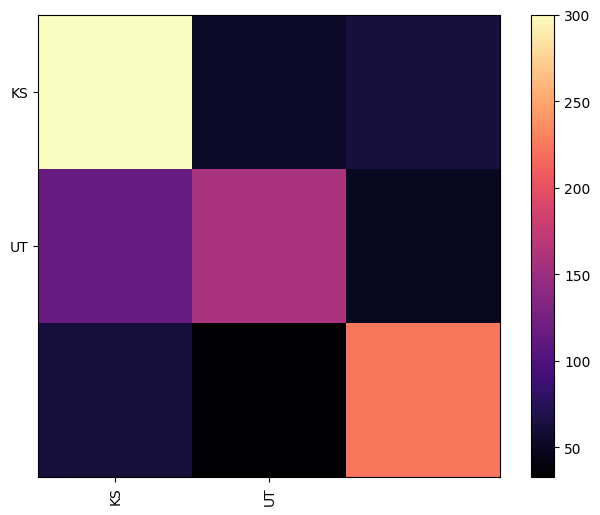

Valores numéricos:


array([[300,  53,  63],
       [116, 159,  50],
       [ 63,  33, 224]])

In [107]:
# Matriz de confusão
text_labels = ['KS','UT']
index = np.arange(len(text_labels))
labels = pd.Series(text_labels, index=index)
plt.imshow(confusion_matrix(y_test, y_pred),cmap='magma')
plt.xticks(labels.index, labels, rotation=90)
plt.yticks(labels.index, labels)
plt.colorbar()
plt.show()
print("Valores numéricos:")
confusion_matrix(y_test,y_pred)

# Pergunta 4: Há alguma relação entre investimento financeiro e igualdade nos esportes?

Para responder essa pergunta, algumas outras precisam ser exploradas: quais são os esportes com mais investimento? Qual é o gênero predominante neles? Qual a proporção dos gêneros neles?

Além disso, nos Estados Unidos, competições esportivas são separadas por níveis: Divisão 1, 2 e 3. Faculdades que competem no nível 1, independente do esporte, são consideradas D1. Essa categoria é a que recebe mais atenção de fãs e participantes e, portanto, mais investimento; por esses motivos elas também acabam influenciando as tendências esportivas universitárias para o resto do país. Atualmente existem 352 faculdades D1, e optamos por analizar as top 50 (pelos Power Rankings da NSCA) para julgar se nesse nível ainda existe muita diferença no investimento entre gêneros, e como a proporção entre eles é afetada, para poder analisar as tendências gerais que essas faculdades acabam desencadeando e também representando.

## Análise Exploratória

### Análise inicial da quantidade total de participantes por gênero, e o investimento individual

* Participantes/esporte: Homens

In [108]:
total_participants_men = df_copy_4.groupby('Sports')['SUM_PARTIC_MEN'].sum().sort_values(ascending=False)
print(total_participants_men)

Sports
Football                                        1392549
Baseball                                         899820
All Track Combined                               691364
Soccer                                           603737
Basketball                                       510243
Lacrosse                                         210401
Golf                                             190360
Tennis                                           155173
Wrestling                                        150929
Track and Field, Outdoor                         142541
Track and Field, X-Country                       111868
Swimming and Diving                               99568
Track and Field and Cross Country (combined)      98712
Track and Field, Indoor                           80012
Ice Hockey                                        68110
Swimming                                          50022
Volleyball                                        44187
Rowing                                   

* Participantes/esporte: Mulheres

In [109]:
total_participants_women = df_copy_4.groupby('Sports')['SUM_PARTIC_WOMEN'].sum().sort_values(ascending=False)
print(total_participants_women)

Sports
All Track Combined                              724077
Soccer                                          585534
Softball                                        493355
Basketball                                      440311
Volleyball                                      416014
Tennis                                          167348
Lacrosse                                        167210
Swimming and Diving                             126521
Track and Field, Outdoor                        124407
Rowing                                          111501
Track and Field, X-Country                      109526
Golf                                            102488
Track and Field and Cross Country (combined)    101428
Field Hockey                                     90624
Track and Field, Indoor                          77387
Swimming                                         64434
Ice Hockey                                       34883
Equestrian                                       32868
Oth

* Investimento total/esporte: Homens

In [110]:
individual_cost_men = df_copy_4.groupby('Sports')['SUM_OPEXPPERPART_MEN'].sum().sort_values(ascending=False)
print(individual_cost_men)

Sports
Basketball                                      304311443
Baseball                                         75578488
Football                                         74992890
Golf                                             72329832
Tennis                                           47155357
Soccer                                           34701357
Ice Hockey                                       19907175
Wrestling                                        11731805
Lacrosse                                         11223845
All Track Combined                               11110253
Swimming and Diving                               9349596
Track and Field, X-Country                        8367476
Volleyball                                        6262243
Swimming                                          4982330
Track and Field, Outdoor                          3630793
Rowing                                            2767645
Skiing                                            2577504
Rodeo  

Os primeiros 10 esportes tem uma diferença considerável de investimento comparados com o resto, e queremos comparar os mesmos esportes entre gêneros. Vamos separar eles para poder analizar:

* Top 10 esportes masculinos:

In [111]:
df_copy_4['Total_Participants_M'] = df_copy_4['SUM_PARTIC_MEN']

grouped = df_copy_4.groupby('Sports').agg({
    'Total_Participants_M': 'sum',
    'SUM_OPEXPPERPART_MEN': 'sum'
})

grouped['Investment_Per_Participant_M'] = grouped['SUM_OPEXPPERPART_MEN'] / grouped['Total_Participants_M']

investment_per_participant_m = grouped['Investment_Per_Participant_M'].sort_values(ascending=False)

# removendo esportes femininos
investment_per_participant_m.dropna(inplace=True)

investment_per_participant_m_10 = investment_per_participant_m.head(10)

* Filtrando os mesmos esportes na categoria feminina:

In [112]:
df_copy_4['Total_Participants_Women'] = df_copy_4['SUM_PARTIC_WOMEN']

grouped = df_copy_4.groupby('Sports').agg({
    'Total_Participants_Women': 'sum',
    'SUM_OPEXPPERPART_WOMEN': 'sum'
})

grouped['Investment_Per_Participant_W'] = grouped['SUM_OPEXPPERPART_WOMEN'] / grouped['Total_Participants_Women']

investment_per_participant_w = grouped['Investment_Per_Participant_W'].sort_values(ascending=False)

#removendo esportes masculinos
investment_per_participant_w.dropna(inplace=True)

investment_per_participant_w_10 = investment_per_participant_w.head(10)

In [113]:
#filtrar pelos esportes masculinos

top_10_sports = investment_per_participant_m_10.index
top_10_investment_per_participant_women = investment_per_participant_w[top_10_sports]

* Investimentos por participante/esporte: comparando gêneros entre os mesmos esportes

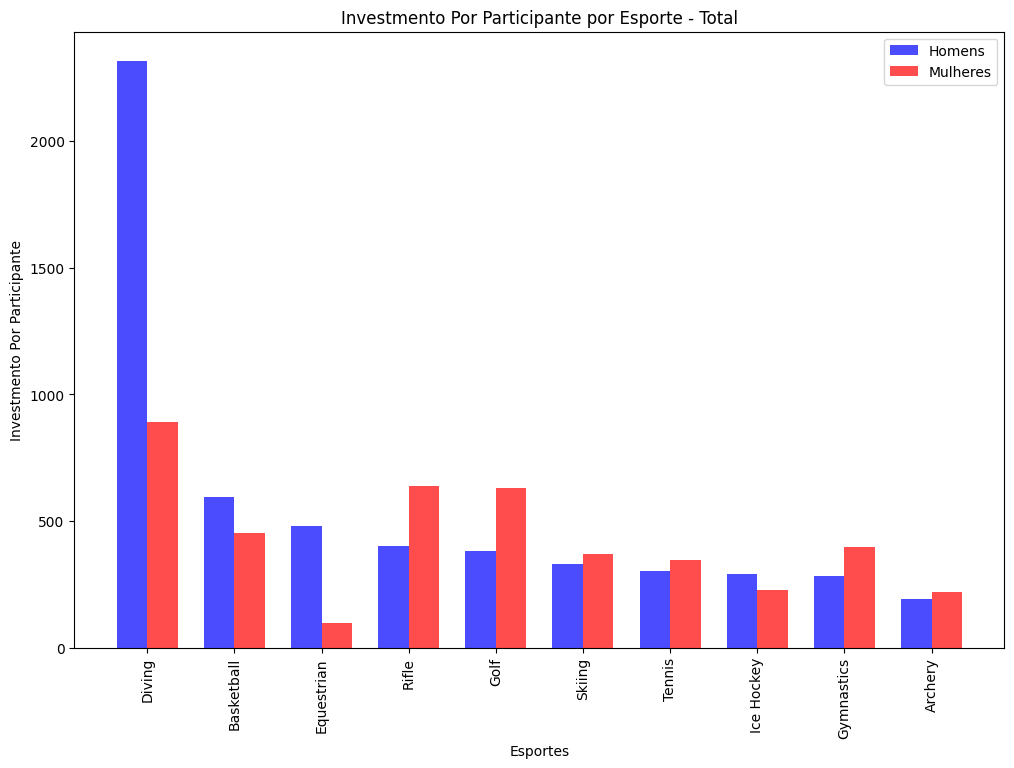

In [114]:
#plot
bar_width = 0.35
index = np.arange(len(top_10_sports))

plt.figure(figsize=(12, 8))
plt.bar(index, investment_per_participant_m_10.values, bar_width, label='Homens', color='blue', alpha=0.7)
plt.bar(index + bar_width, top_10_investment_per_participant_women.values, bar_width, label='Mulheres', color='red', alpha=0.7)
plt.xlabel('Esportes')
plt.ylabel('Investmento Por Participante')
plt.title('Investmento Por Participante por Esporte - Total')
plt.xticks(index + bar_width / 2, top_10_sports, rotation=90)
plt.legend()
plt.show()

Podemos observar que a maior discrepância é no salto ornamental (diving), e todos os outros esportes, considerando todos os anos e todas as faculdades da base, não tem diferenças tão significativas. Inclusive, o investimento individual tende a ser maior para mulheres, com 6 dos 10 esportes apresentando essa tendência.

* Número de participantes/esporte: comparando gêneros

In [115]:
total_participants_men_10 = total_participants_men[top_10_sports]
total_participants_women_10 = total_participants_women[top_10_sports]

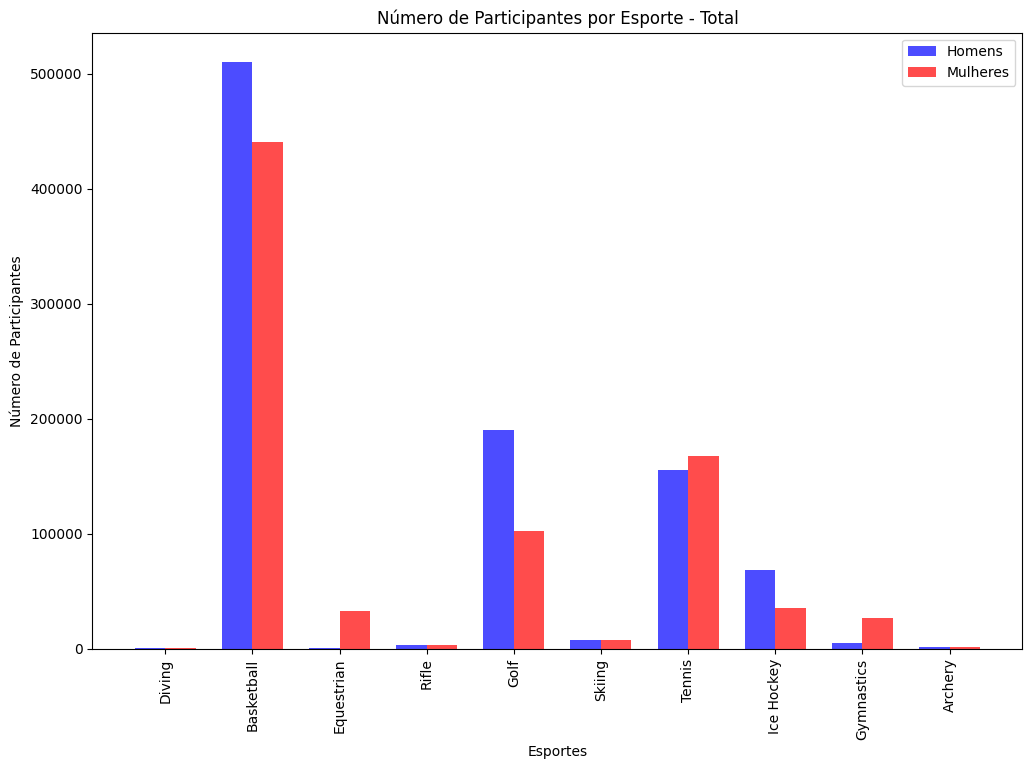

In [116]:
plt.figure(figsize=(12, 8))
plt.bar(index, total_participants_men_10.values, bar_width, label='Homens', color='blue', alpha=0.7)
plt.bar(index + bar_width, total_participants_women_10.values, bar_width, label='Mulheres', color='red', alpha=0.7)
plt.xlabel('Esportes')
plt.ylabel('Número de Participantes')
plt.title('Número de Participantes por Esporte - Total')
plt.xticks(index + bar_width / 2, top_10_sports, rotation=90)
plt.legend()
plt.show()

Observando as proporções de participantes, podemos extrair algumas informações: o basquete tem mais investimento por jogador masculino mesmo tendo mais jogadores, o que teoricamente diminuiria o investimento por pessoa - indica uma desigualdade, principalmente comparando com hockey e tênis.

A discrepância no salto onrnamental pode ser explicada pela quantidade pequena de dados do esporte.

Uma situação parecida com o basquete acontece com a equitação, ao contrário. Será que é explicado pelos intervalos de confiança?

* Boxplots para o intervalo de confiança da soma de gastos, por esporte e gênero:

In [117]:
df_novo = df_copy_4[['SUM_OPEXPPERPART_WOMEN', 'SUM_OPEXPPERPART_MEN', 'Sports']]
df_novo = df_novo[df_novo['Sports'].isin(top_10_sports)]

#retirando times que tem 0 participantes na modalidade feminina ou masculina
df_novo_w = df_novo[df_novo['SUM_OPEXPPERPART_WOMEN'] != 0]
df_novo_m = df_novo[df_novo['SUM_OPEXPPERPART_MEN'] != 0]

* Homens:

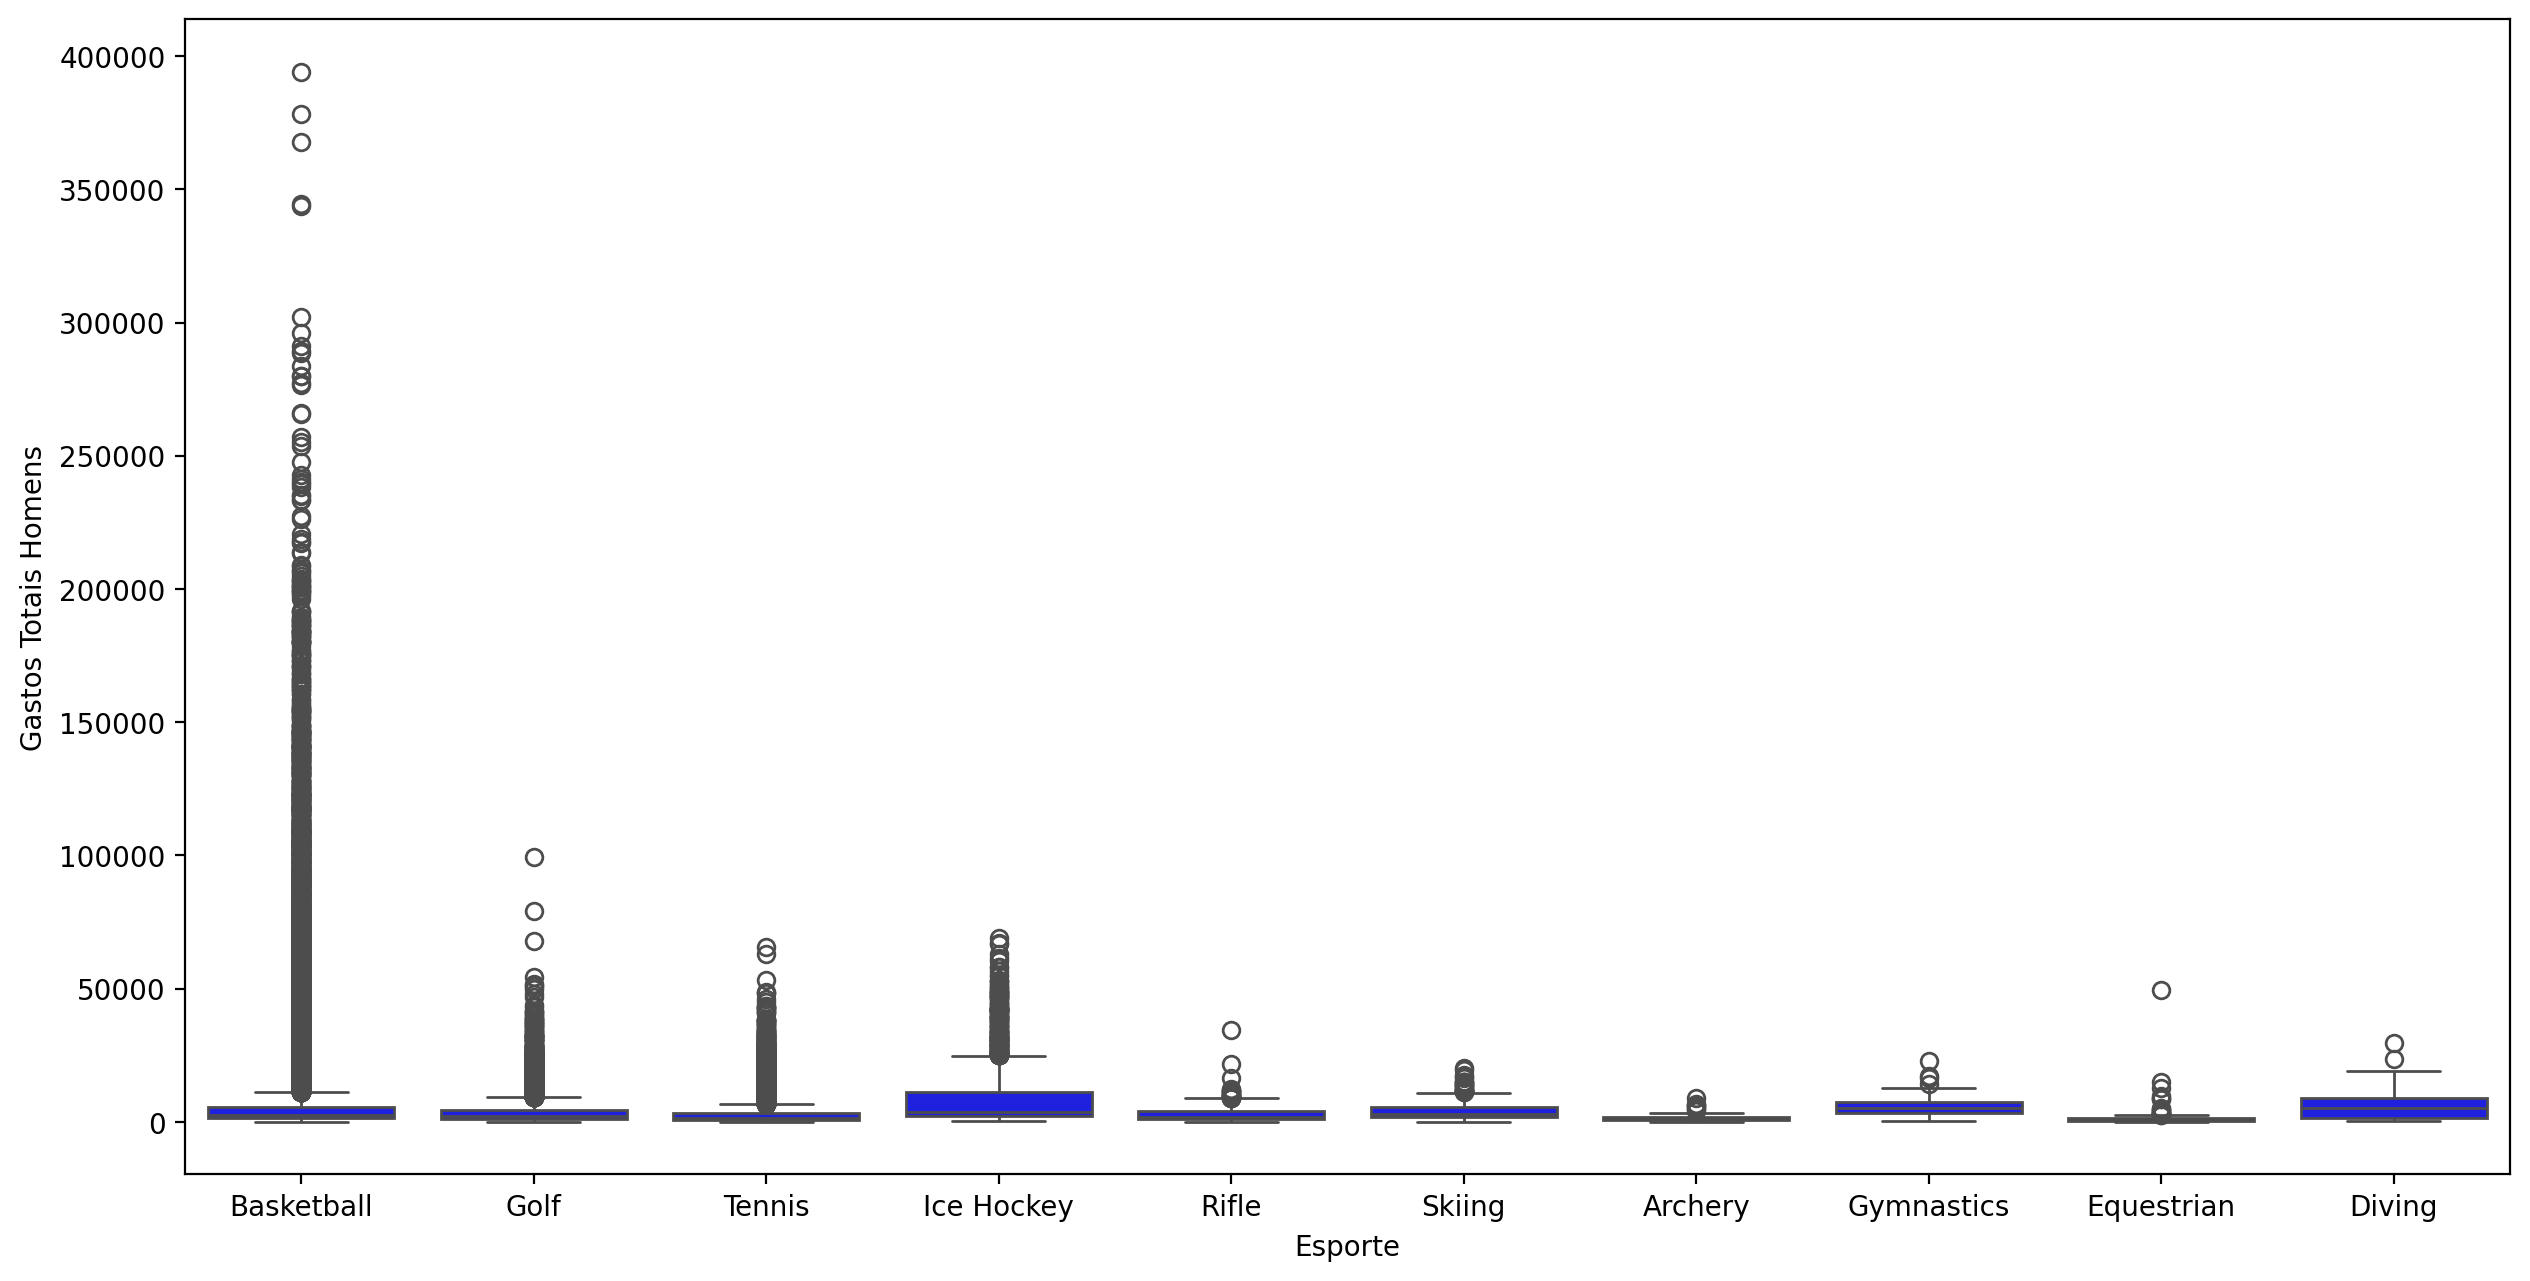

In [118]:
plt.subplots(figsize=(15, 7.5), dpi =200)
sns.set(style = "white")

ax = sns.boxplot(data = df_novo_m, x = 'Sports', y = 'SUM_OPEXPPERPART_MEN', color='Blue')
ax.set(xlabel = 'Esporte', ylabel = 'Gastos Totais Homens')
plt.show()

* Mulheres:

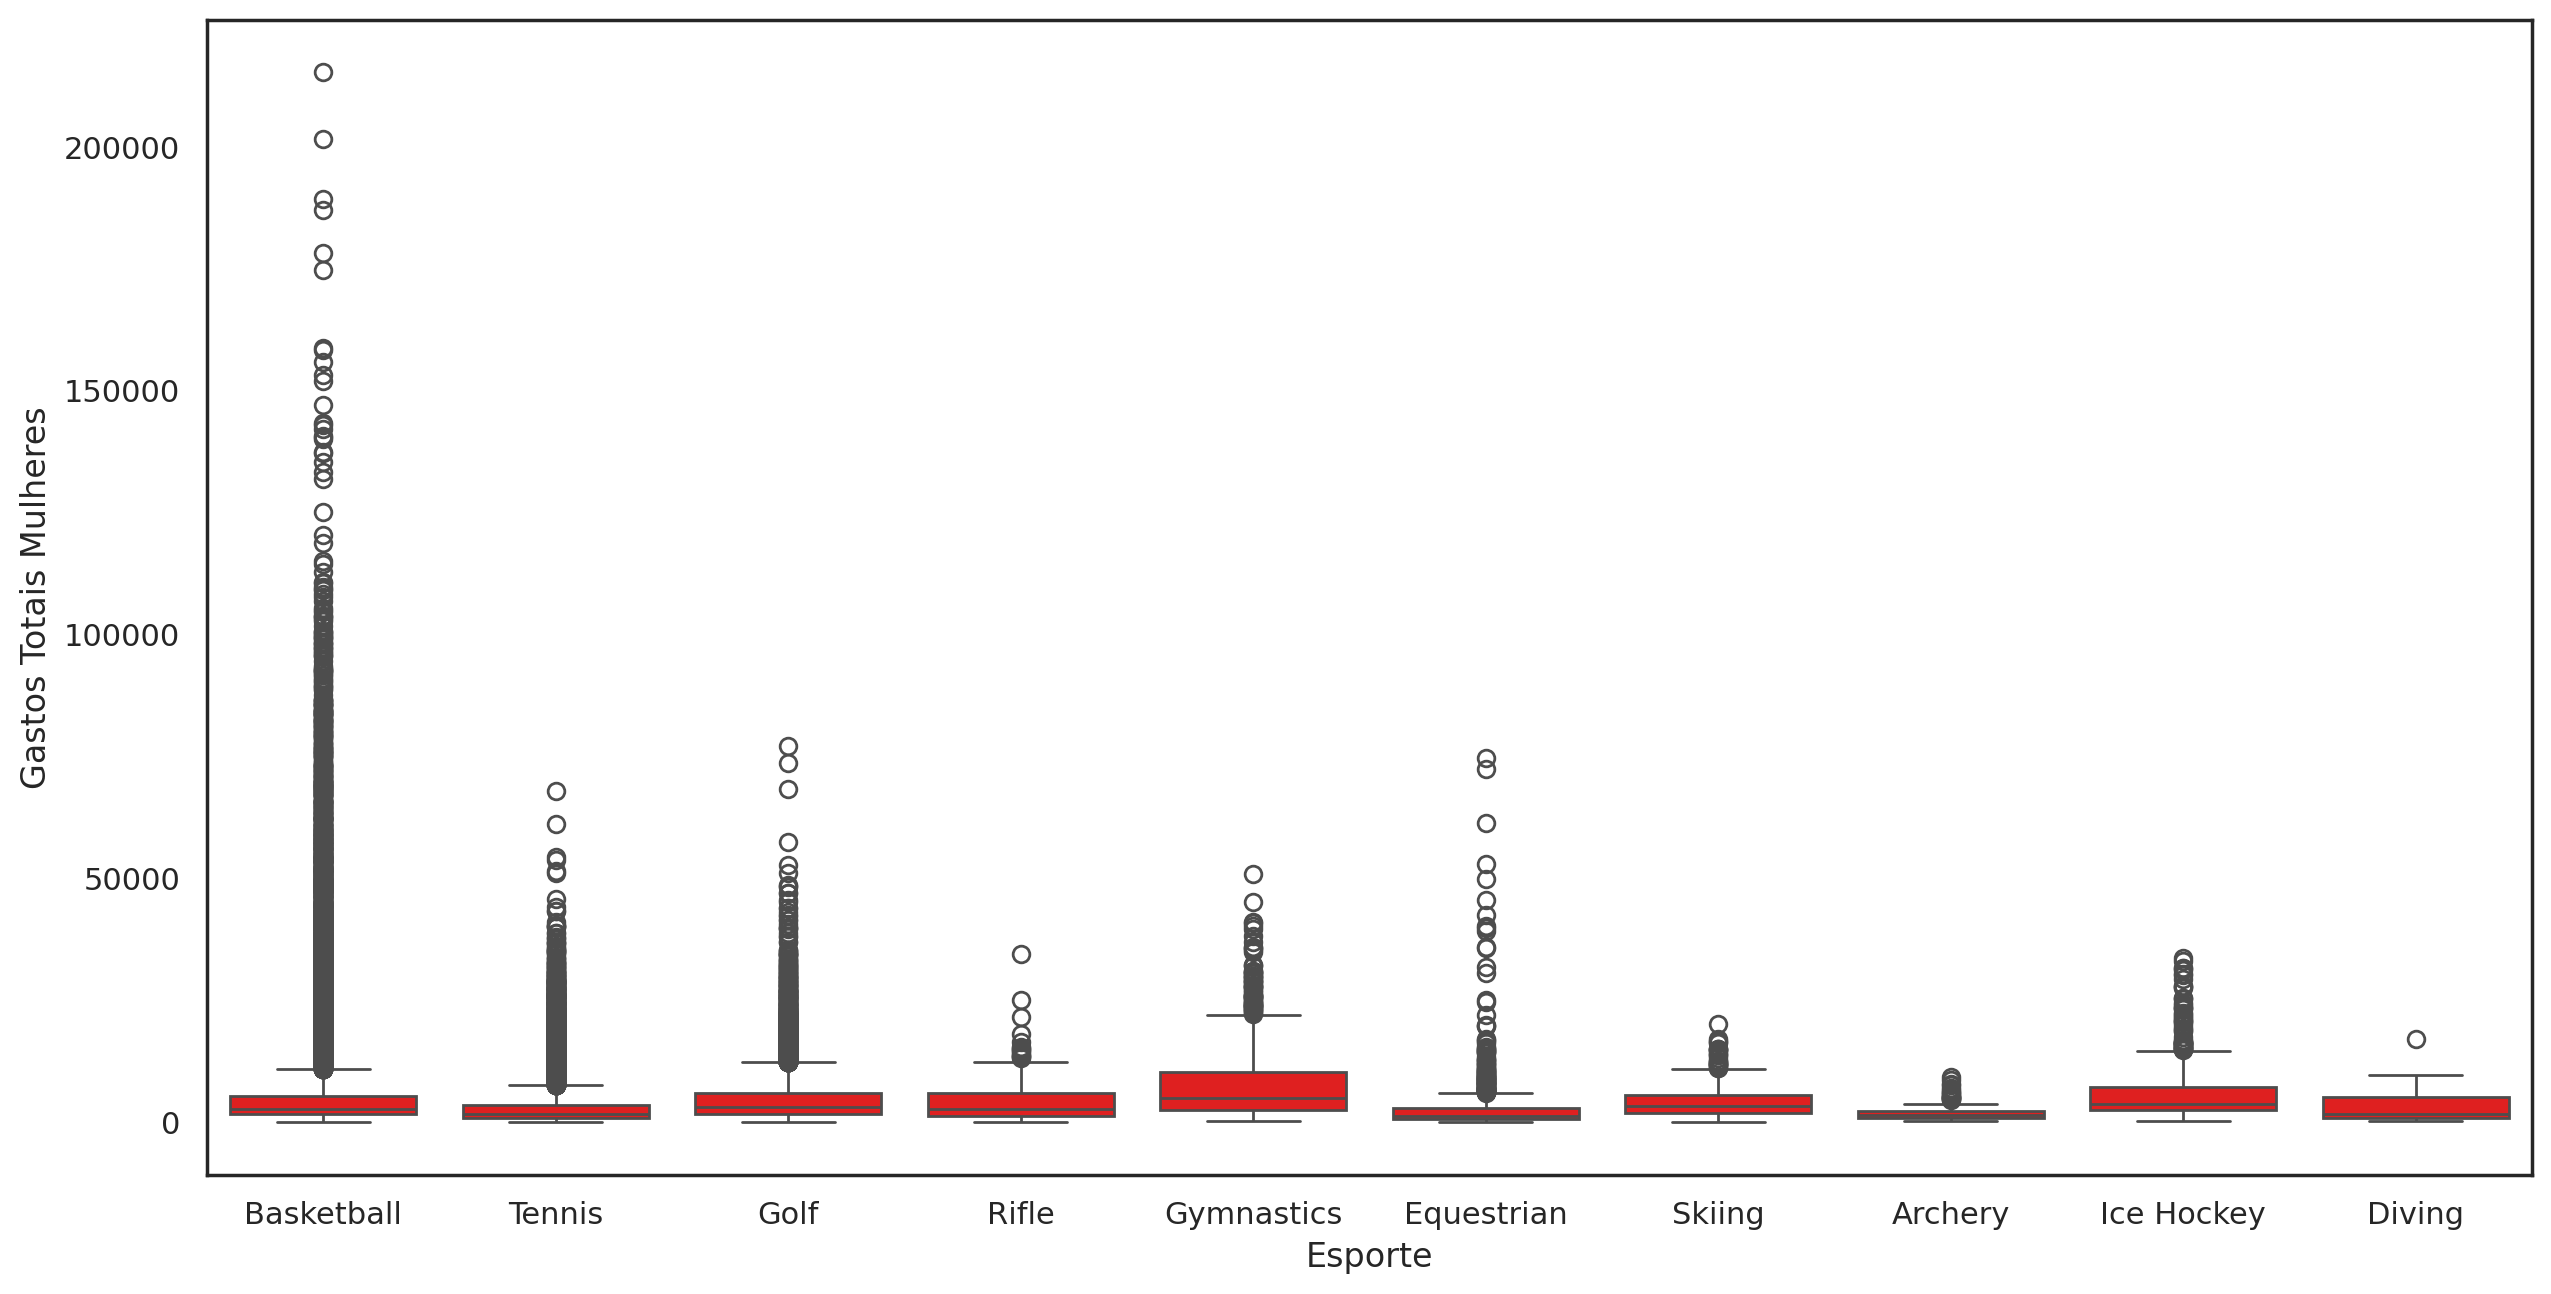

In [119]:
plt.subplots(figsize=(15, 7.5), dpi =200)
sns.set(style = "white")

ax = sns.boxplot(data = df_novo_w, x = 'Sports', y = 'SUM_OPEXPPERPART_WOMEN', color = 'Red')
ax.set(xlabel = 'Esporte', ylabel = 'Gastos Totais Mulheres')

plt.show()

## Análise das Top 50 Faculdades no nível D1

Considerando os dados extremamente fora da curva nos boxplots, os times com muitos gastos, mostrados como outliers, provavelmente pertencem à faculdades D1. Iremos, então, responder às perguntais iniciais propostas considerando as 50 melhores faculdades dessa categoria.

A maioria é focada em um esporte - baseball, basquete, futebol americano e futebol são os mais comuns; É interessante explorar a disparidade do investimento focando em áreas diferentes.

In [120]:
top_50_colleges = ['Stanford University',
'University of Florida',
'University of California-Los Angeles',
'Princeton University',
'Harvard University',
'University of Michigan',
'University of North Carolina at Chapel Hill',
'University of California-Berkeley',
'Duke University',
'Yale University',
'Columbia University',
'University of Pennsylvania-Penn',
'University of Virginia',
'University of Notre Dame',
'University of Texas-Austin',
'Vanderbilt University',
'University of Georgia',
'Ohio State University',
'Florida State University',
'Georgia Tech',
'University of Southern California',
'University of Wisconsin',
'Northwestern University',
'Georgetown University',
'Clemson University',
'Brown University',
'University of Washington',
'North Carolina State University',
'Michigan State University',
'Purdue University',
'Texas A&M University',
'University of Maryland',
'Cornell University',
'Virginia Tech',
'Wake Forest University',
'University of California-Santa Barbara',
'University of California-San Diego',
'University of Miami',
'Boston College',
'University of Illinois',
'Indiana University',
'Dartmouth College',
'Rice University',
'Auburn University',
'University of Minnesota',
'University of California-Davis',
'University of South Florida',
'University of California-Irvine',
'Villanova University',
'University of Pittsburgh'
]

In [121]:
df_top_50 = df.query(f"institution_name in {top_50_colleges}")
df_top_50.head()

unitid                   institution_name            addr1_txt addr2_txt  \
797  110635  University of California-Berkeley  200 California Hall       NaN   
798  110635  University of California-Berkeley  200 California Hall       NaN   
799  110635  University of California-Berkeley  200 California Hall       NaN   
800  110635  University of California-Berkeley  200 California Hall       NaN   
801  110635  University of California-Berkeley  200 California Hall       NaN   

     city_txt state_cd   zip_text  ClassificationCode classification_name  \
797  Berkeley       CA  947201500                   1   NCAA Division I-A   
798  Berkeley       CA  947201500                   1   NCAA Division I-A   
799  Berkeley       CA  947201500                   1   NCAA Division I-A   
800  Berkeley       CA  947201500                   1   NCAA Division I-A   
801  Berkeley       CA  947201500                   1   NCAA Division I-A   

    ClassificationOther  ...  TOTAL_EXP_MENWOMEN  EXP_COED_MEN  \
797                 NaN  ...           1086869.0           NaN   
798                 NaN  ...           6117777.0           NaN   
799                 NaN  ...           1817054.0           NaN   
800                 NaN  ...            429219.0           NaN   
801                 NaN  ...          17283717.0           NaN   

     EXP_COED_WOMEN  TOTAL_EXP_COED EXPENSE_MENALL  EXPENSE_WOMENALL  \
797             NaN             NaN        1086869                 0   
798             NaN             NaN        3840457           2277320   
799             NaN             NaN         845907            971147   
800             NaN             NaN              0            429219   
801             NaN             NaN       17283717                 0   

     TOTAL_EXPENSE_ALL              Sports  YEAR  OPEID  
797            1086869            Baseball  2006    NaN  
798            6117777          Basketball  2006    NaN  
799            1817054  All Track Combined  2006    NaN  
800             429219         Field hocky  2006    NaN  
801           17283717            Football  2006    NaN  

[5 rows x 130 columns]

* Uma mesma faculdade tem muita diferença ao longo dos anos entre os gastos totais nos seus esportes?:

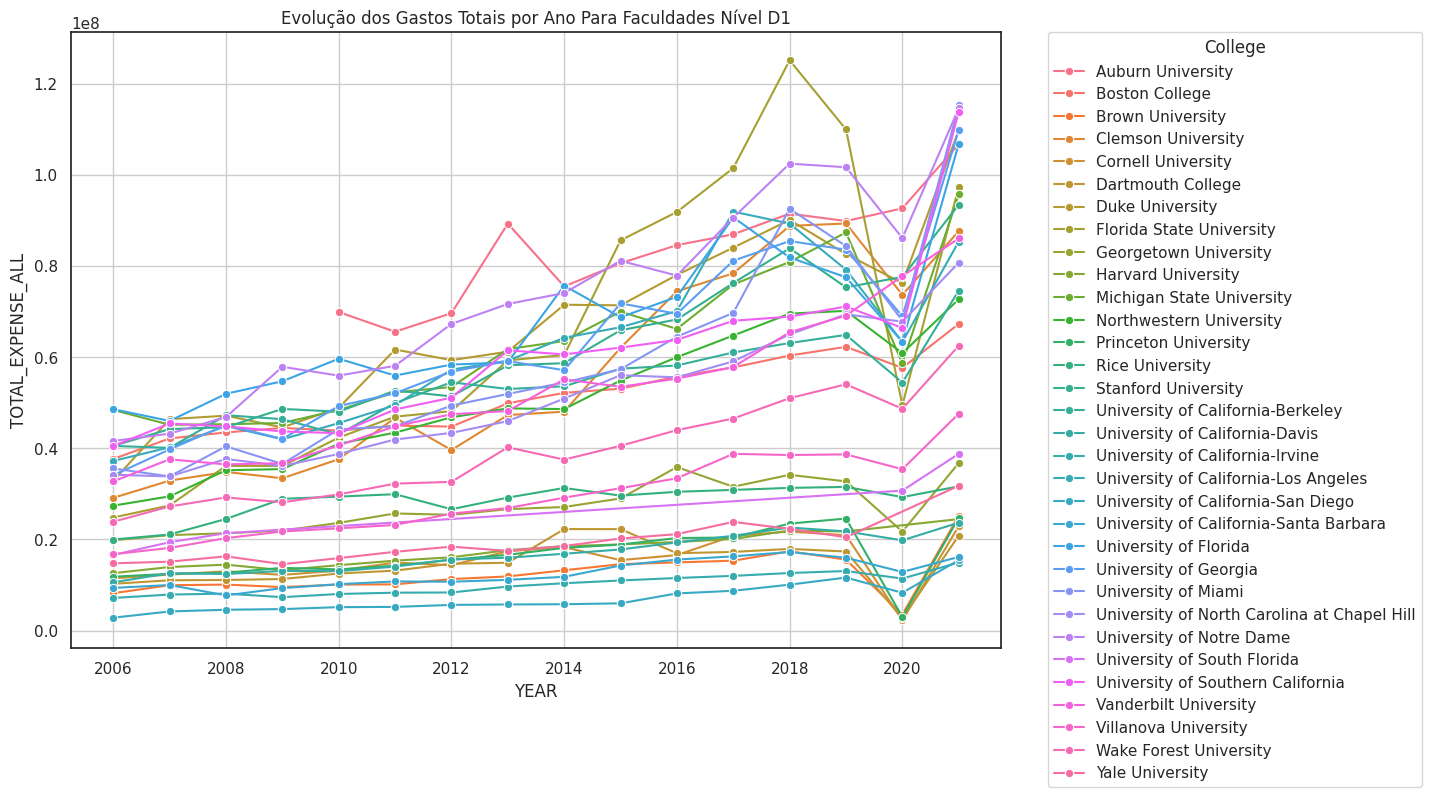

In [122]:
instituicao_gastos = df_top_50.groupby(['institution_name', 'YEAR'])['TOTAL_EXPENSE_ALL'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(data=instituicao_gastos, x='YEAR', y='TOTAL_EXPENSE_ALL', hue='institution_name', marker='o')
plt.title('Evolução dos Gastos Totais por Ano Para Faculdades Nível D1')
plt.xlabel('YEAR')
plt.ylabel('TOTAL_EXPENSE_ALL')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,title='College')
plt.grid(True)
plt.show()

Podemos observar que a tendência de crescimento no investimento está presente entre todas as faculdades, embora tenha sido afetada durante a pandemia.

Pensando no ano mais recente da base, que é o que teve maior investimento total somado, vamos analizar a diferença de investimentos entre os esportes dentro de cada faculdade.

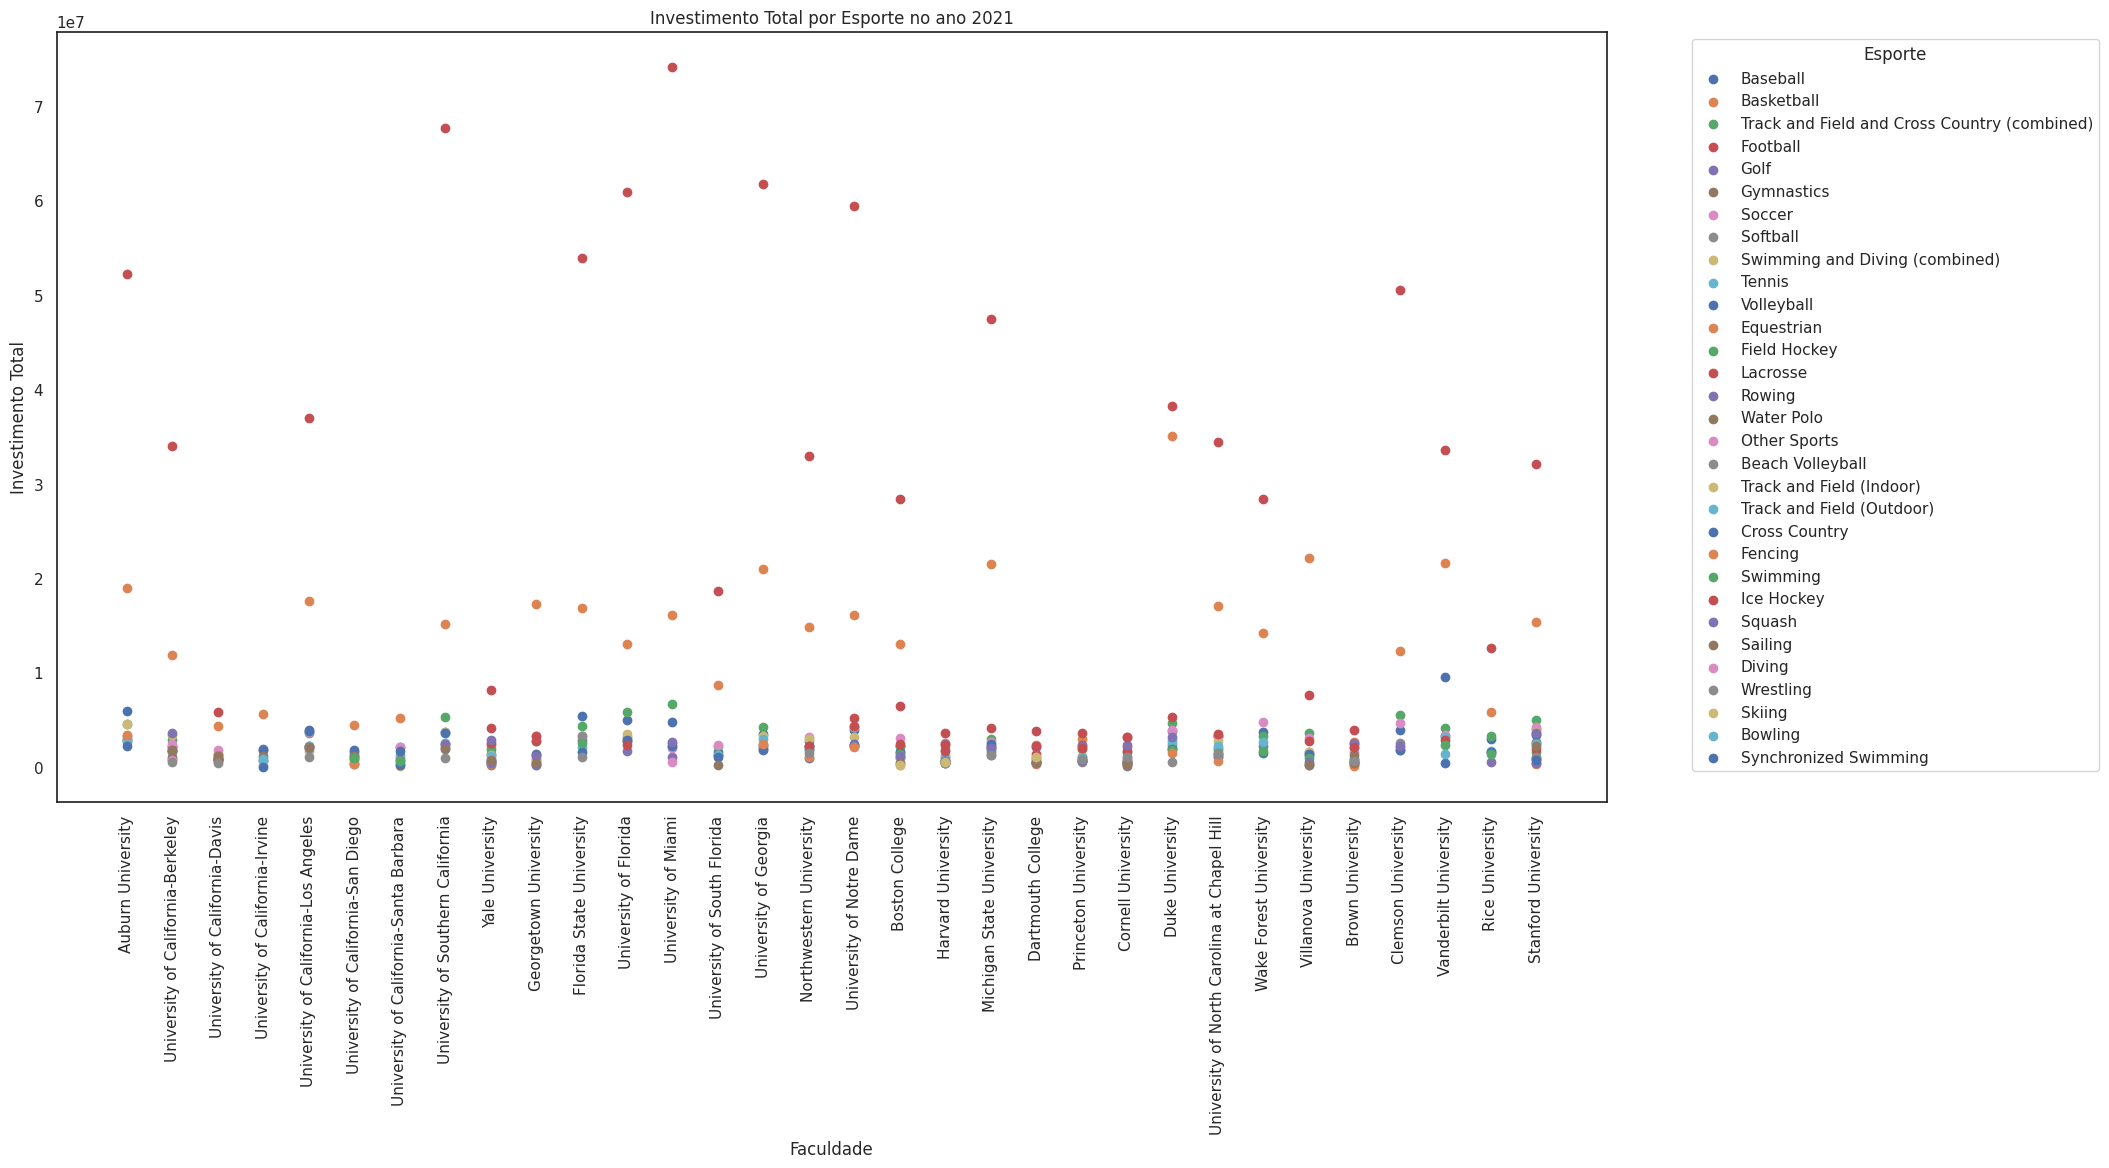

In [123]:
# gráfico do investimento total naquele ano naquele esporte por faculdade (agrupado por faculdade)
year = 2021

df_filtered = df_top_50[df_top_50['YEAR'] == year]

plt.figure(figsize=(20, 10))
for sport in df_filtered['Sports'].unique():
    df_sport = df_filtered[df_filtered['Sports'] == sport]
    plt.scatter(df_sport['institution_name'], df_sport['TOTAL_EXPENSE_ALL'], label=sport)

plt.xlabel('Faculdade')
plt.ylabel('Investimento Total')
plt.title(f'Investimento Total por Esporte no ano {year}')
plt.xticks(rotation=90)
plt.legend(title='Esporte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

A maioria dos esportes recebeu menos que 5 milhões de investimento total no ano, mas basquete e futebol americano são consistentemente o foco das faculdades.

Separando os dados como uma núvem de pontos:

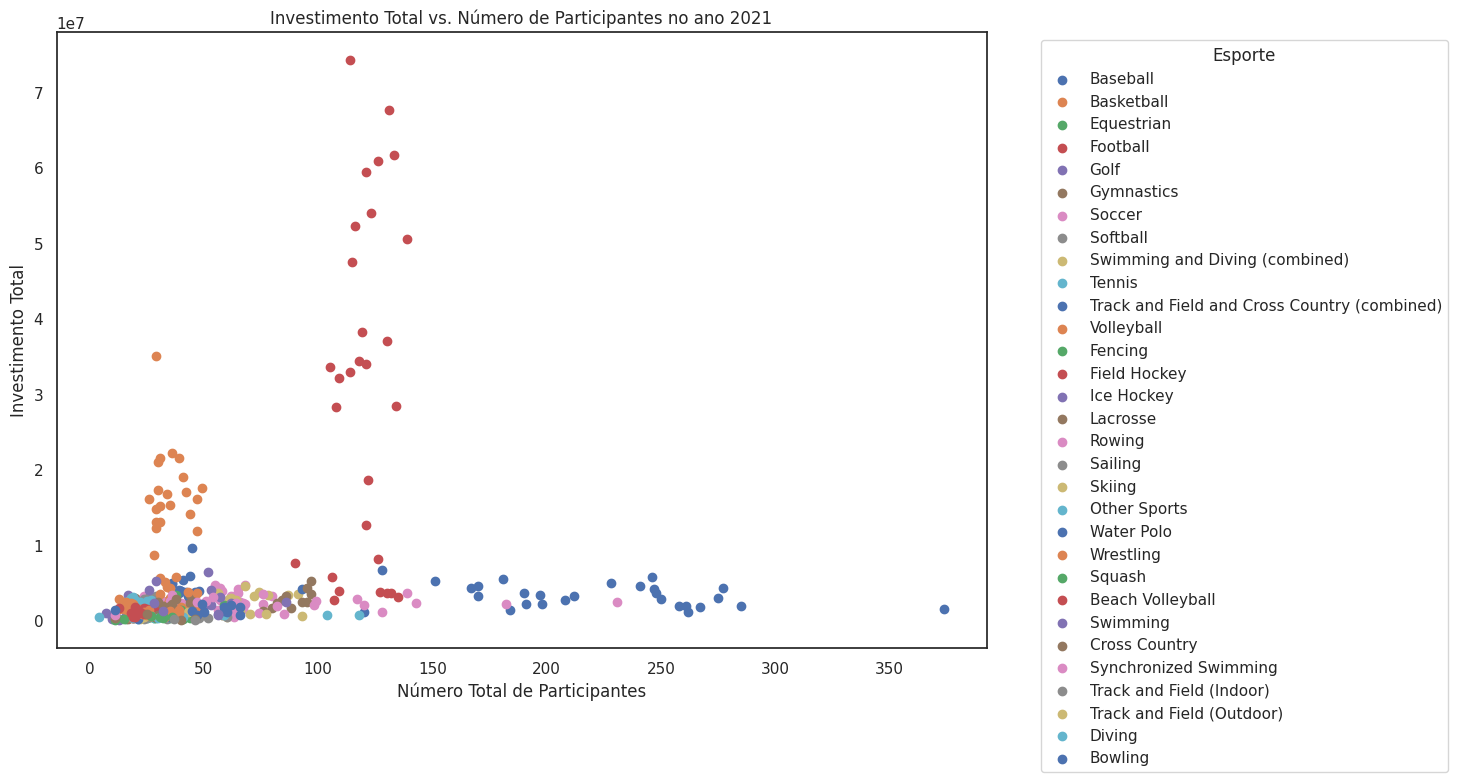

In [124]:
df_filtered = df_top_50[df_top_50['YEAR'] == year]

df_participants = df_filtered.groupby(['institution_name', 'Sports'])[['SUM_PARTIC_MEN', 'SUM_PARTIC_WOMEN', 'TOTAL_EXPENSE_ALL']].sum().reset_index() # Include 'TOTAL_EXPENSE_ALL' in the groupby
df_participants['Total_Participants'] = df_participants['SUM_PARTIC_MEN'] + df_participants['SUM_PARTIC_WOMEN']

plt.figure(figsize=(12, 8))
for sport in df_participants['Sports'].unique():
    df_sport = df_participants[df_participants['Sports'] == sport]
    plt.scatter(df_sport['Total_Participants'], df_sport['TOTAL_EXPENSE_ALL'], label=sport)

plt.xlabel('Número Total de Participantes')
plt.ylabel('Investimento Total')
plt.title(f'Investimento Total vs. Número de Participantes no ano {year}')
plt.legend(title='Esporte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.style.context('seaborn-v0_8-bright')
#plt.tight_layout()
plt.show()

Mesma análise, agora focando na diferença entre o investimento masculino e feminino:

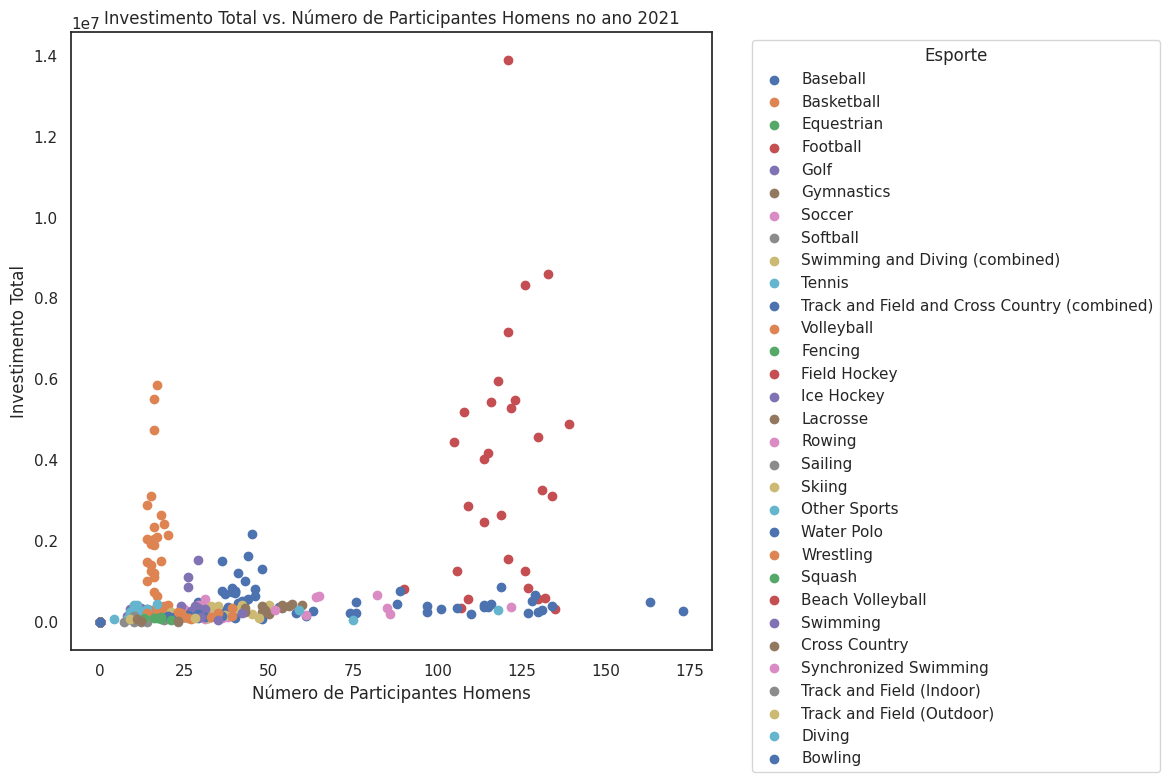

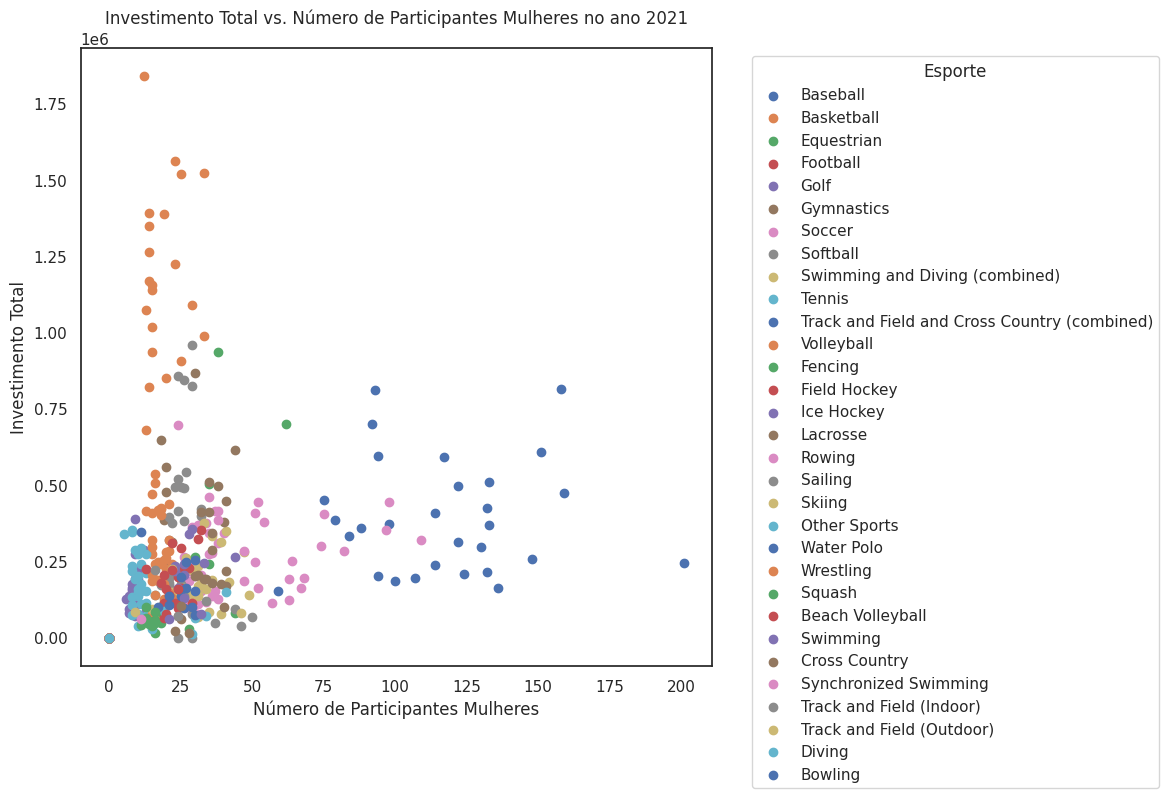

In [125]:
df_filtered = df_top_50[df_top_50['YEAR'] == year]

df_participants = df_filtered.groupby(['institution_name', 'Sports'])[['SUM_PARTIC_MEN', 'SUM_PARTIC_WOMEN','OPEXPPERTEAM_WOMEN', 'OPEXPPERTEAM_MEN'
]].sum().reset_index()

# Homens
plt.figure(figsize=(12, 8))
for sport in df_participants['Sports'].unique():
    df_sport = df_participants[df_participants['Sports'] == sport]
    plt.scatter(df_sport['SUM_PARTIC_MEN'], df_sport['OPEXPPERTEAM_MEN'], label=sport)

plt.xlabel('Número de Participantes Homens')
plt.ylabel('Investimento Total')
plt.title(f'Investimento Total vs. Número de Participantes Homens no ano {year}')
plt.legend(title='Esporte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Mulheres
plt.figure(figsize=(12, 8))
for sport in df_participants['Sports'].unique():
    df_sport = df_participants[df_participants['Sports'] == sport]
    plt.scatter(df_sport['SUM_PARTIC_WOMEN'], df_sport['OPEXPPERTEAM_WOMEN'], label=sport)

plt.xlabel('Número de Participantes Mulheres')
plt.ylabel('Investimento Total')
plt.title(f'Investimento Total vs. Número de Participantes Mulheres no ano {year}')
plt.legend(title='Esporte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Vamos focar no basquete, considerando conclusões prévias sobre o futebol americano, para poder analisar a equidade entre essas faculdades.

* Investimento por participantes/ano: Homens

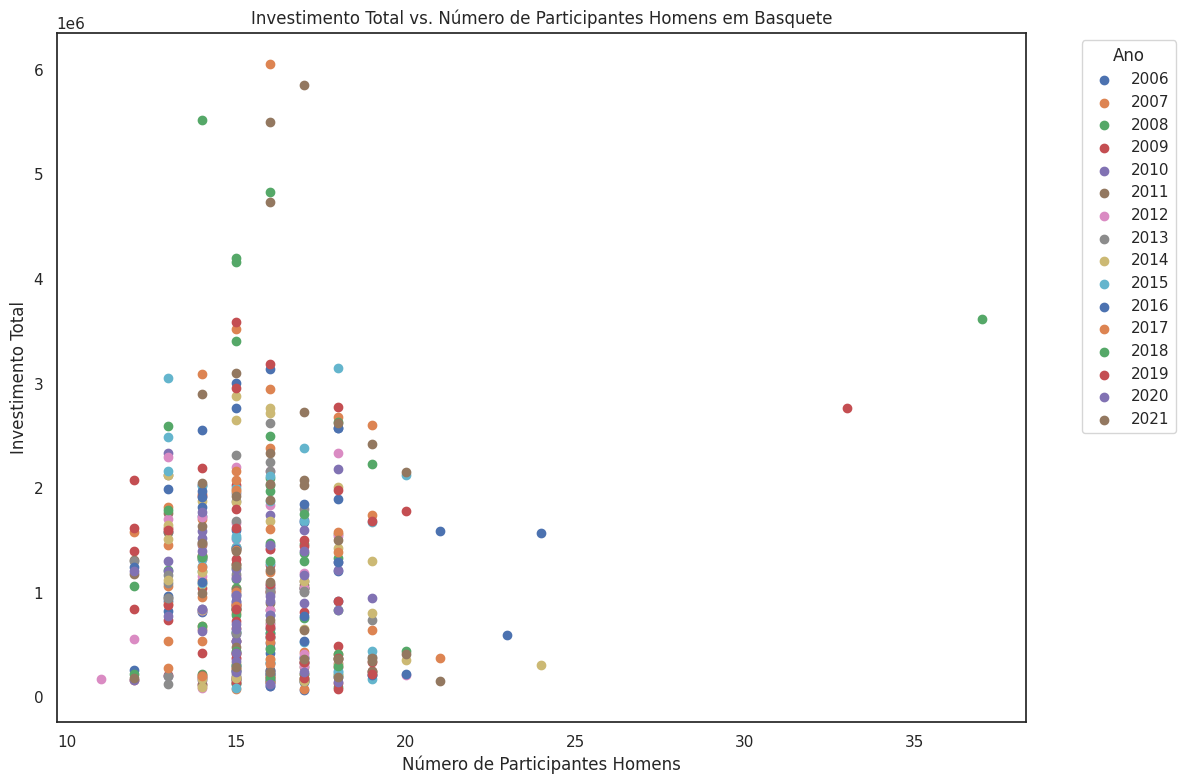

In [126]:
df_filtered_b = df_top_50[df_top_50['Sports'] == 'Basketball']

df_participants_b = df_filtered_b[['institution_name', 'YEAR', 'SUM_PARTIC_MEN', 'SUM_PARTIC_WOMEN','OPEXPPERTEAM_WOMEN', 'OPEXPPERTEAM_MEN']]

# Homens
plt.figure(figsize=(12, 8))

for year in df_participants_b['YEAR'].unique():
    df_year = df_participants_b[df_participants_b['YEAR'] == year]
    plt.scatter(df_year['SUM_PARTIC_MEN'], df_year['OPEXPPERTEAM_MEN'], label=year)

plt.xlabel('Número de Participantes Homens')
plt.ylabel('Investimento Total')
plt.title(f'Investimento Total vs. Número de Participantes Homens em Basquete')
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

* Investimento por participantes/ano: Mulheres

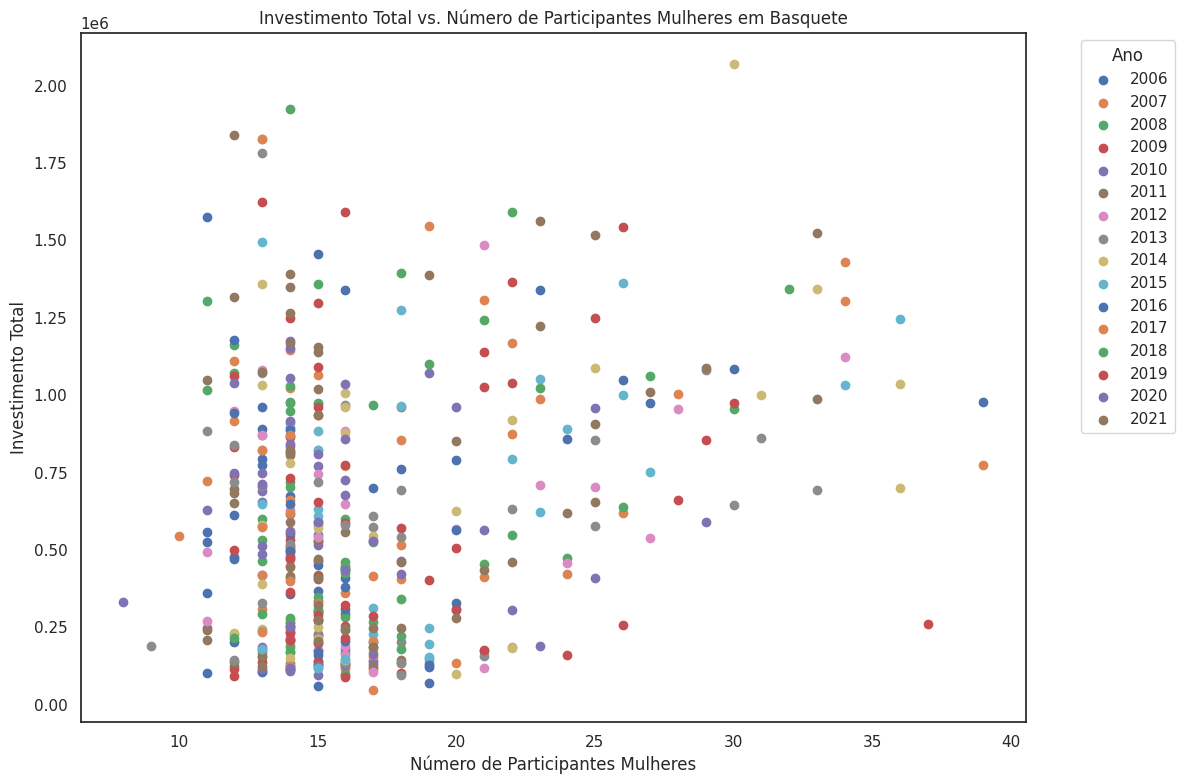

In [127]:
# Mulheres
plt.figure(figsize=(12, 8))
for year in df_participants_b['YEAR'].unique():
    df_year = df_participants_b[df_participants_b['YEAR'] == year]
    plt.scatter(df_year['SUM_PARTIC_WOMEN'], df_year['OPEXPPERTEAM_WOMEN'], label=year)

plt.xlabel('Número de Participantes Mulheres')
plt.ylabel('Investimento Total')
plt.title(f'Investimento Total vs. Número de Participantes Mulheres em Basquete')
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Regressão: Influência do gênero no investimento

Para poder analizar profundamente a disparidade de gênero entre as 50 faculdades, considerando as análises prévias, iremos realizar uma regressão logística tomando o ano e os esportes como variáveis.

Filtramos a base, comparando o investimento entre as equipes femininas e masculinas quando estão ambas presentes em uma faculdade, e criando uma coluna de 0s e 1s quando o investimento é maior na primeira ou na segunda, respectivamente. Além disso, utilizamos one-hot encoding para poder separar e analizar a influência dos esportes.

Uma regressão logística padrão é, então, aplicada à esses dados.

In [128]:
df = df_top_50.copy()

# 1 se o investimento no time masculino é maior, 0 se não
df['Gender_Disparity'] = (df['OPEXPPERTEAM_MEN'] > df['OPEXPPERTEAM_WOMEN']).astype(int)

# variáveis
X = df[['Sports', 'YEAR']]
# saída
y = df['Gender_Disparity']

X = pd.get_dummies(X, columns=['Sports'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
total = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.7790311877903119


* Mostrando todos os coeficientes:

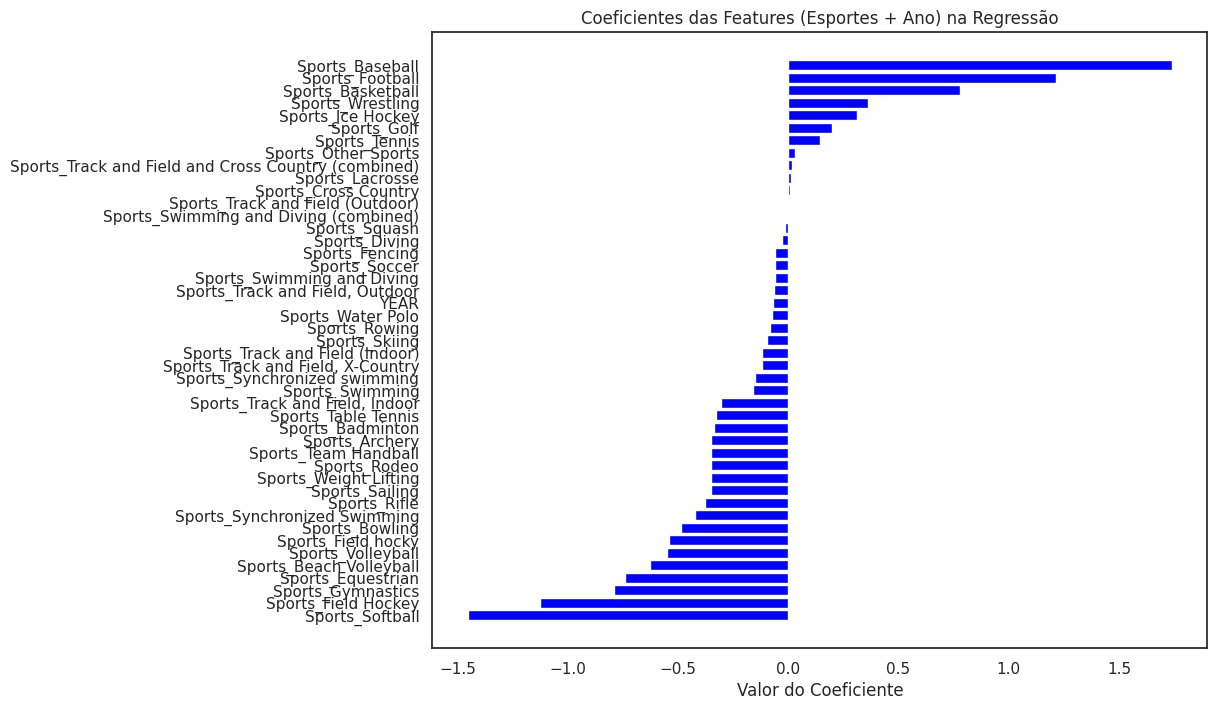

In [129]:
coefficients = model.coef_[0]

feature_names = X.columns

coef_feature_pairs = sorted(zip(coefficients, feature_names), key=lambda x: x[0])

sorted_coefficients, sorted_features = zip(*coef_feature_pairs)

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color='blue')

plt.xlabel('Valor do Coeficiente')

plt.title('Coeficientes das Features (Esportes + Ano) na Regressão')
plt.show()

Podemos ver que esportes tradicionalmente femininos (softball e ginástica, por ex.) tendem à terem coeficientes negativos por terem mais investimento nas equipes femininas, e a mesma tendência é observada nos masculinos (baseball e futebol americano). Impressionantemente, os masculinos não possuem coeficiente muito maior do que basquete, mesmo tendo investimento muito discrepante comparado aos femininos.